In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, linalg
from tqdm import tqdm
import itertools
from scipy.spatial import ConvexHull

# Моделирование движения ЛА

## Нелинейные уравнения движения

In [2]:
# Определение функций изменения параметров со временем
def Delta_V(t):
    return 10 * np.abs(np.sin(2 * t))

def Delta_Alpha(t):
    return 3 * np.sin(0.5 * t)

def Sigma(t):
    return 5 * np.sin(0.3 * t)

def P(t):
    return 15 * np.abs(np.sin(1 * t))

In [3]:
def equations_of_motion(t, state):
    V, theta, phi, Omega = state
    alpha = phi - theta  
    delta_alpha_val = Delta_Alpha(t)
    delta_V_val = Delta_V(t)
    sigma_val = Sigma(t)
    X = 0.5 * rho * (V + delta_V_val)**2 * S * (c0x + B * (c0y + c_alpha_y * (alpha + delta_alpha_val))**2)
    Y = 0.5 * rho * (V + delta_V_val)**2 * S * (c0y + c_alpha_y * (alpha + delta_alpha_val))
    Mz = -0.5 * rho * (V + delta_V_val)**2 * S * b * (m_alpha_z * (alpha + delta_alpha_val) + m_sigma_z * sigma_val)
    
    dV_dt = (-M * g * np.sin(theta) + P(t) * np.cos(alpha) - X) / M
    dtheta_dt = (-g * np.cos(theta) / V +  P(t) * np.sin(alpha) + Y) / (M * V)
    dphi_dt = Omega
    dOmega_dt = -Mz / Jz
    
    return [dV_dt, dtheta_dt, dphi_dt, dOmega_dt]

In [4]:
rho = 1.125
g = 9.81

# Як-55
M = 1000
S = 14.805
c0x = 0.035
B = 0.07
c0y = 0
c_alpha_y = 4.3
b = 1.746

Jz = 1600
# m_alpha_z = 1.975
# m_sigma_z = 0

m_alpha_z = 1.26
m_sigma_z = 0.0481

# Як-52
# S = 15
# c0x = 0.0375
# B = 0.062
# c0y = 4.81
# c_alpha_y = 4.81
# b = 1.640
# Jz = 2000




# начальные условия
# V0 = 100
# theta0 = -0.3
# phi0 = -0.1
# Omega0 = -0.1

V0 = 100
theta0 = -0.3
phi0 = -0.1
Omega0 = -0.1

initial_state = [V0, theta0, phi0, Omega0]

t_start = 0
t_end = 30
dt = 0.01
t_span = (t_start, t_end)

In [5]:
solution = integrate.solve_ivp(equations_of_motion,
                     t_span,
                     initial_state,
                     t_eval=np.arange(t_start, t_end, dt)
                    )

#t_values = solution.t
V_values, theta_values, phi_values, Omega_values = solution.y
t_values = np.linspace(0, t_end, len(V_values)) #solution.t

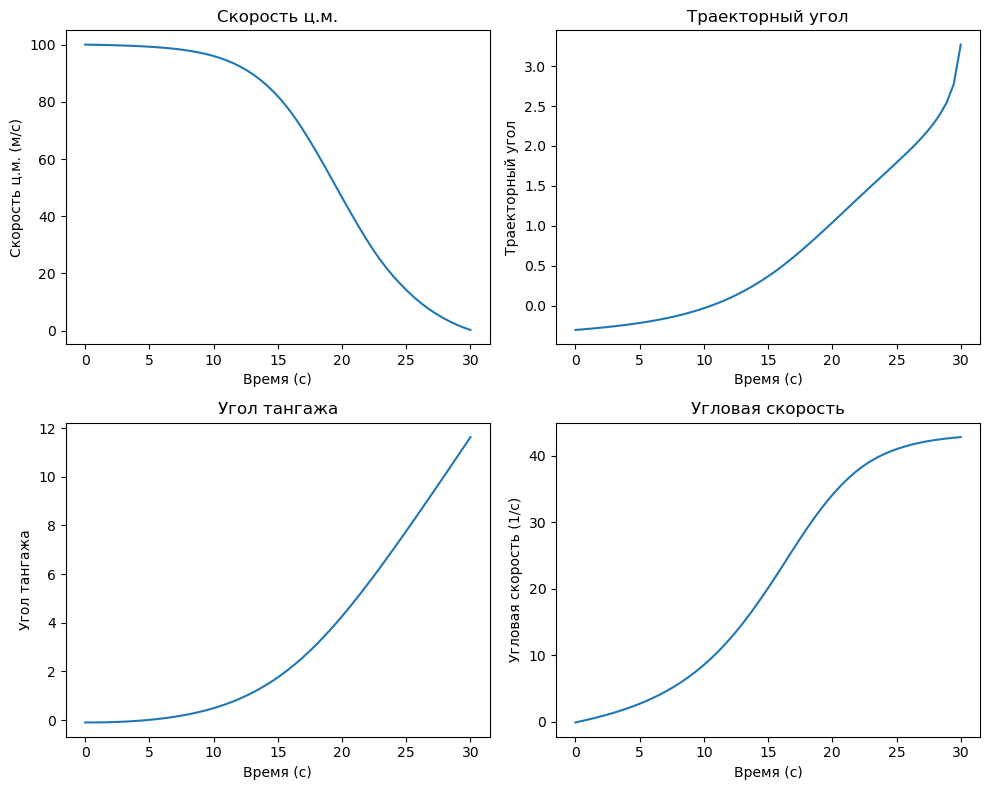

In [6]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(t_values, V_values)
plt.xlabel('Время (с)')
plt.ylabel('Скорость ц.м. (м/с)')
plt.title('Скорость ц.м.')

plt.subplot(2, 2, 2)
plt.plot(t_values, theta_values)
plt.xlabel('Время (с)')
plt.ylabel('Траекторный угол')
plt.title('Траекторный угол')

plt.subplot(2, 2, 3)
plt.plot(t_values, phi_values)
plt.xlabel('Время (с)')
plt.ylabel('Угол тангажа')
plt.title('Угол тангажа')

plt.subplot(2, 2, 4)
plt.plot(t_values, Omega_values)
plt.xlabel('Время (с)')
plt.ylabel('Угловая скорость (1/с)')
plt.title('Угловая скорость')

plt.tight_layout()
plt.show()

## Линеаризованные уравнения движения

In [7]:
rho = 1.125
g = 9.81

# Як-55
M = 1000
S = 14.805
c0x = 0.035
B = 0.07
c0y = 0
c_alpha_y = 4.3
b = 1.746

Jz = 1600
# m_alpha_z = 1.975
# m_sigma_z = 0

m_alpha_z = 1.26
m_sigma_z = 0.0481

# Як-52
# S = 15
# c0x = 0.0375
# B = 0.062
# c0y = 4.81
# c_alpha_y = 4.81
# b = 1.640
# Jz = 2000

In [8]:
# определение характерных значений для обезразмеривания
M_har = 1000
V_har = 100
Omega_har = 1
T_har = 10

# обозначение безразмерных коэффициентов
h = rho * S * T_har * V_har / M_har
q = rho * S * b * T_har * (V_har**2) / (Jz * Omega_har)

In [9]:
V_prog = 1
alpha_prog = 0
theta_prog = -2
P_prog = 1.3
sigma_prog = 3


a11 = h*V_prog*(c0x + B*(c0y**2 + 2*c0y*c_alpha_y*alpha_prog + (c_alpha_y**2)*(alpha_prog**2)))
a13 = -h*B*c_alpha_y*(V_prog**2)*(c0y + c_alpha_y*alpha_prog) - P_prog * np.sin(alpha_prog)
a12 = -a13

a21 = 0.5*h*(c0y + c_alpha_y*alpha_prog) + np.cos(theta_prog) / (V_prog**2) - P_prog*np.sin(alpha_prog) / (V_prog**2)
a23 = 0.5*h*c_alpha_y*V_prog + P_prog*np.cos(alpha_prog) / V_prog
a22 = -a23

a41 = -q*V_prog*(m_alpha_z*alpha_prog + m_sigma_z*sigma_prog)
a43 = -0.5*q*m_alpha_z*(V_prog**2)
a42 = -a43

matrix_A = np.array([[a11, a12, a13, 0.],
                     [a21, a22, a23, 0.],
                     [0., 0., 0., 1.],
                     [a41, a42, a43, 0.]])


b11 = np.cos(alpha_prog)
b21 = np.sin(alpha_prog) / V_prog
b42 = -0.5*q*m_sigma_z*(V_prog**2)

matrix_B = np.array([[b11, 0.],
                     [b21, 0.],
                     [0., 0.],
                     [0., b42]])

c11 = h*V_prog*(c0x + B*(c0y**2 + 2*c0y*c_alpha_y*alpha_prog + (c_alpha_y**2)*(alpha_prog**2)))
c12 = h*B*(V_prog**2)*(c0y*c_alpha_y + (c_alpha_y**2)*alpha_prog)

c21 = h*(c0y + c_alpha_y*alpha_prog)
c22 = 0.5*h*c_alpha_y*V_prog

c41 = -q*V_prog*(m_alpha_z*alpha_prog + m_sigma_z*sigma_prog)
c42 = -0.5*q*m_sigma_z*(V_prog**2)

matrix_C = np.array([[c11, c12],
                     [c21, c22],
                     [0., 0.],
                     [c41, c42]])


In [10]:
def linear_equation_of_motion(t, state):
    control = np.array([Delta_P(t), Delta_Sigma(t)])
    disturbance = np.array([Delta_V(t), Delta_Alpha(t)])
    
    return matrix_A @ state + matrix_B @ control + matrix_C @ disturbance

In [11]:
amplitude_ratio = 1

def Delta_V(t):
    # return 1 * np.abs(np.sin(2 * t))
    return amplitude_ratio*1 * np.abs(np.sin(2 * t))

    
def Delta_Alpha(t):
    return amplitude_ratio*2 * np.sin(0.5 * t)

def Delta_Sigma(t):
    return amplitude_ratio*3 * np.sin(0.3 * t)

def Delta_P(t):
    return amplitude_ratio*1.5 * np.abs(np.sin(1 * t))

In [12]:
#x0 = [0, 0, 0, 0]

init_ratio = 2

np.random.seed(42)
x0 = init_ratio * np.random.random(4)

t_start = 0
t_end = 10
dt = 0.01
t_span = (t_start, t_end)

solution = integrate.solve_ivp(linear_equation_of_motion,
                     t_span,
                     x0,
                     t_eval=np.arange(t_start, t_end, dt)
                    )

#t_values = solution.t
V_values, theta_values, phi_values, Omega_values = solution.y
t_values = np.linspace(0, t_end, len(V_values)) #solution.t

x0 = [0.74908024 1.90142861 1.46398788 1.19731697]


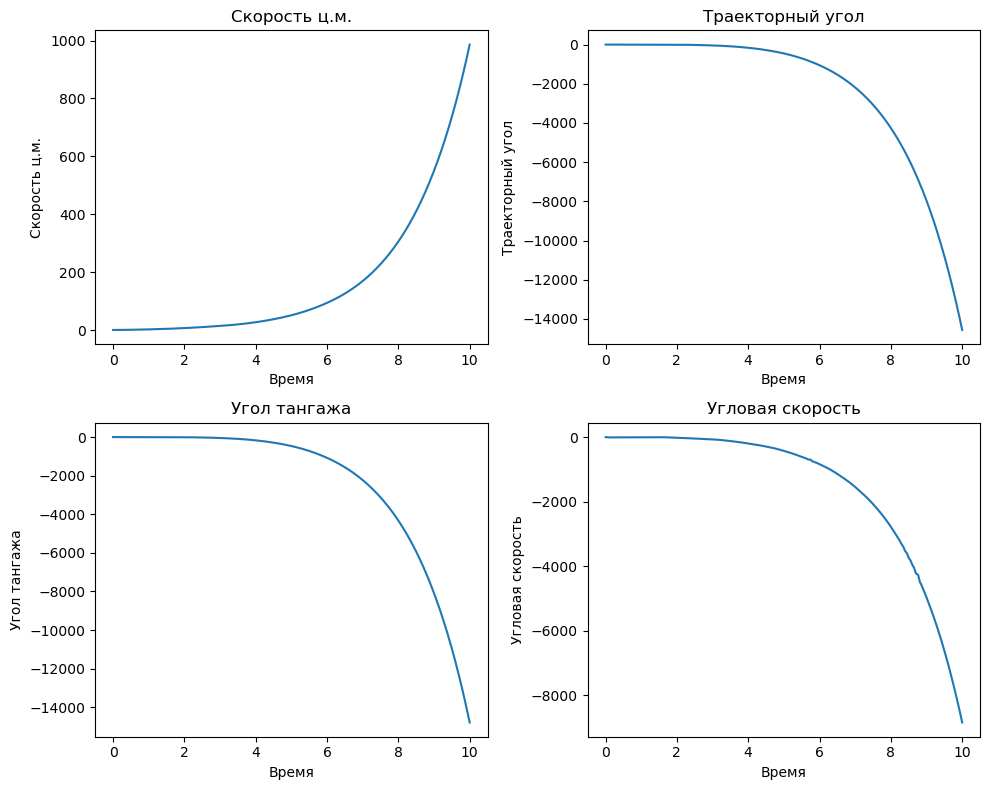

In [13]:
print(f'x0 = {x0}')

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(t_values, V_values)
plt.xlabel('Время')
plt.ylabel('Скорость ц.м.')
plt.title('Скорость ц.м.')

plt.subplot(2, 2, 2)
plt.plot(t_values, theta_values)
plt.xlabel('Время')
plt.ylabel('Траекторный угол')
plt.title('Траекторный угол')

plt.subplot(2, 2, 3)
plt.plot(t_values, phi_values)
plt.xlabel('Время')
plt.ylabel('Угол тангажа')
plt.title('Угол тангажа')

plt.subplot(2, 2, 4)
plt.plot(t_values, Omega_values)
plt.xlabel('Время')
plt.ylabel('Угловая скорость')
plt.title('Угловая скорость')

plt.tight_layout()
plt.show()

In [14]:
amplitude_ratio = 1

def Delta_V(t):
    # return 1 * np.abs(np.sin(2 * t))
    return amplitude_ratio*1 * np.abs(np.sin(2 * t))

    
def Delta_Alpha(t):
    return amplitude_ratio*2 * np.sin(0.5 * t)

def Delta_Sigma(t):
    return amplitude_ratio*3 * np.sin(0.3 * t)

def Delta_P(t):
    return amplitude_ratio*1.5 * np.abs(np.sin(1 * t))

In [15]:
#x0 = [0, 0, 0, 0]

init_ratio = 2

np.random.seed(42)
x0 = init_ratio * np.random.random(4)

t_start = 0
t_end = 1
dt = 0.01
t_span = (t_start, t_end)

solution = integrate.solve_ivp(linear_equation_of_motion,
                     t_span,
                     x0,
                     t_eval=np.arange(t_start, t_end, dt)
                    )

#t_values = solution.t
V_values1, theta_values1, phi_values1, Omega_values1 = solution.y
t_values = np.linspace(0, t_end, len(V_values1)) #solution.t

In [16]:
print(x0 / 2)

[0.37454012 0.95071431 0.73199394 0.59865848]


x0 = [0.74908024 1.90142861 1.46398788 1.19731697]


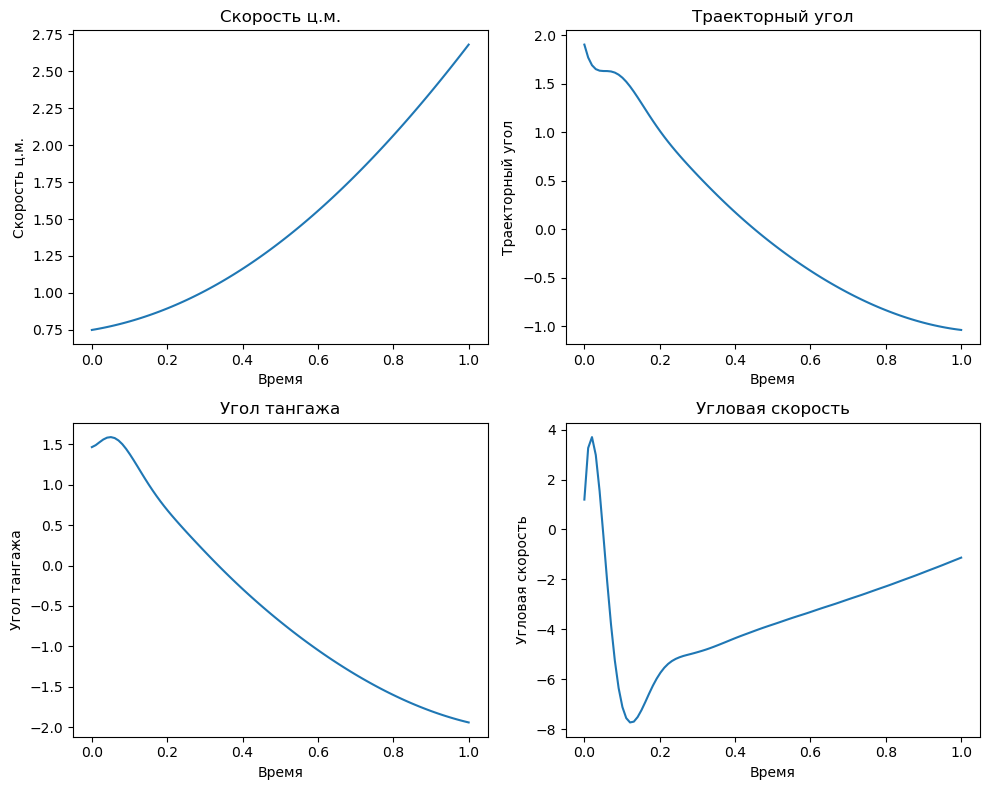

In [17]:
print(f'x0 = {x0}')

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(t_values, V_values1)
plt.xlabel('Время')
plt.ylabel('Скорость ц.м.')
plt.title('Скорость ц.м.')

plt.subplot(2, 2, 2)
plt.plot(t_values, theta_values1)
plt.xlabel('Время')
plt.ylabel('Траекторный угол')
plt.title('Траекторный угол')

plt.subplot(2, 2, 3)
plt.plot(t_values, phi_values1)
plt.xlabel('Время')
plt.ylabel('Угол тангажа')
plt.title('Угол тангажа')

plt.subplot(2, 2, 4)
plt.plot(t_values, Omega_values1)
plt.xlabel('Время')
plt.ylabel('Угловая скорость')
plt.title('Угловая скорость')

plt.tight_layout()
plt.show()

In [18]:
amplitude_ratio = 10

def Delta_V(t):
    # return 1 * np.abs(np.sin(2 * t))
    return amplitude_ratio*1 * np.abs(np.sin(2 * t))

    
def Delta_Alpha(t):
    return amplitude_ratio*2 * np.sin(0.5 * t)

def Delta_Sigma(t):
    return amplitude_ratio*3 * np.sin(0.3 * t)

def Delta_P(t):
    return amplitude_ratio*1.5 * np.abs(np.sin(1 * t))

In [19]:
#x0 = [0, 0, 0, 0]

init_ratio = 2

np.random.seed(42)
x0 = init_ratio * np.random.random(4)

t_start = 0
t_end = 1
dt = 0.01
t_span = (t_start, t_end)

solution = integrate.solve_ivp(linear_equation_of_motion,
                     t_span,
                     x0,
                     t_eval=np.arange(t_start, t_end, dt)
                    )

#t_values = solution.t
V_values2, theta_values2, phi_values2, Omega_values2 = solution.y
t_values = np.linspace(0, t_end, len(V_values2)) #solution.t

x0 = [0.74908024 1.90142861 1.46398788 1.19731697]


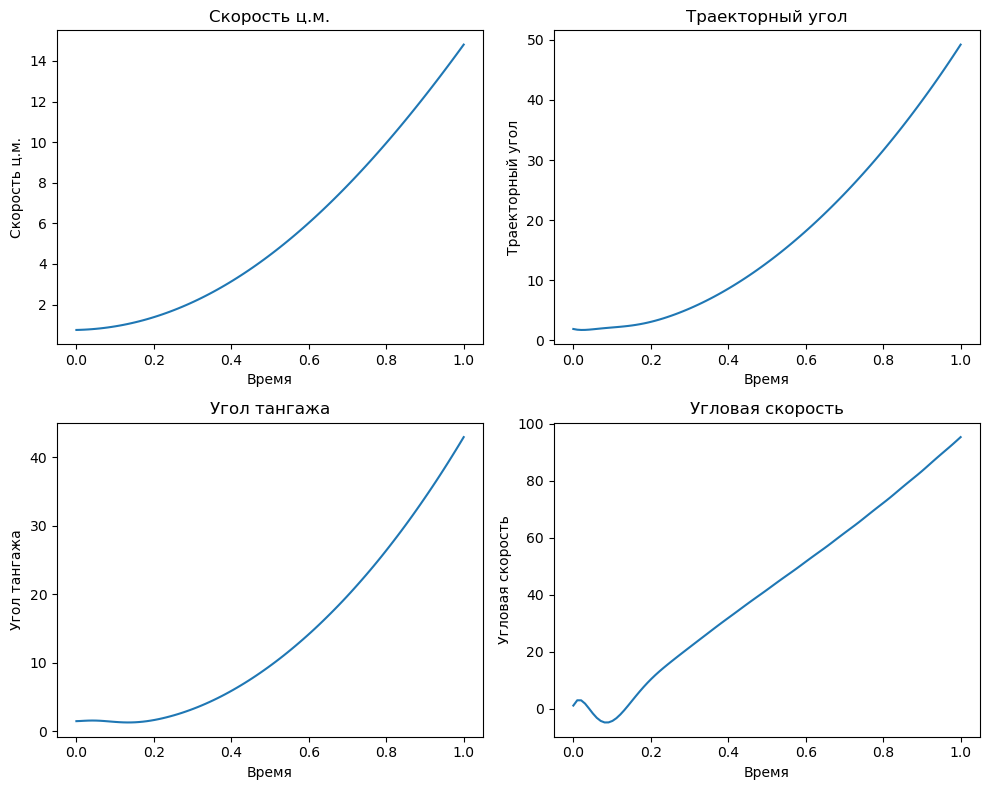

In [20]:
print(f'x0 = {x0}')

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(t_values, V_values2)
plt.xlabel('Время')
plt.ylabel('Скорость ц.м.')
plt.title('Скорость ц.м.')

plt.subplot(2, 2, 2)
plt.plot(t_values, theta_values2)
plt.xlabel('Время')
plt.ylabel('Траекторный угол')
plt.title('Траекторный угол')

plt.subplot(2, 2, 3)
plt.plot(t_values, phi_values2)
plt.xlabel('Время')
plt.ylabel('Угол тангажа')
plt.title('Угол тангажа')

plt.subplot(2, 2, 4)
plt.plot(t_values, Omega_values2)
plt.xlabel('Время')
plt.ylabel('Угловая скорость')
plt.title('Угловая скорость')

plt.tight_layout()
plt.show()

In [21]:
amplitude_ratio = 1

def Delta_V(t):
    # return 1 * np.abs(np.sin(2 * t))
    return amplitude_ratio*1 * np.abs(np.sin(2 * t))

    
def Delta_Alpha(t):
    return amplitude_ratio*2 * np.sin(0.5 * t)

def Delta_Sigma(t):
    return amplitude_ratio*3 * np.sin(0.3 * t)

def Delta_P(t):
    return amplitude_ratio*1.5 * np.abs(np.sin(1 * t))

In [22]:
#x0 = [0, 0, 0, 0]

init_ratio = 100

np.random.seed(42)
x0 = init_ratio * np.random.random(4)

t_start = 0
t_end = 1
dt = 0.01
t_span = (t_start, t_end)

solution = integrate.solve_ivp(linear_equation_of_motion,
                     t_span,
                     x0,
                     t_eval=np.arange(t_start, t_end, dt)
                    )

#t_values = solution.t
V_values3, theta_values3, phi_values3, Omega_values3 = solution.y
t_values = np.linspace(0, t_end, len(V_values3)) #solution.t

x0 = [37.45401188 95.07143064 73.19939418 59.86584842]


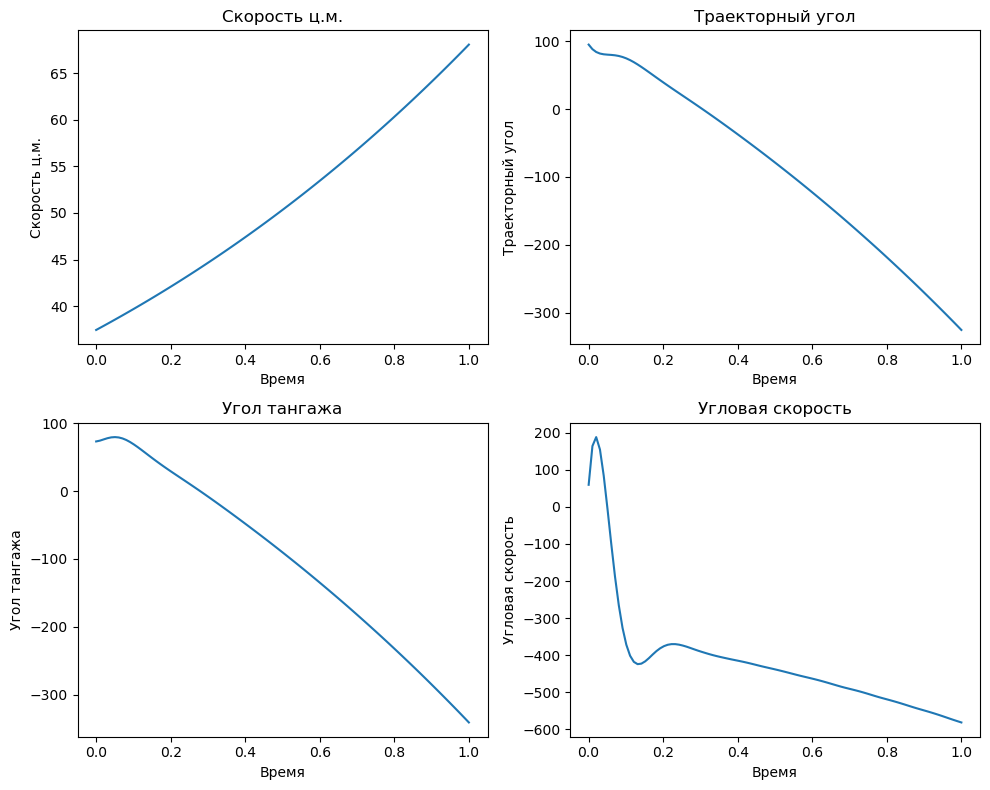

In [23]:
print(f'x0 = {x0}')

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(t_values, V_values3)
plt.xlabel('Время')
plt.ylabel('Скорость ц.м.')
plt.title('Скорость ц.м.')

plt.subplot(2, 2, 2)
plt.plot(t_values, theta_values3)
plt.xlabel('Время')
plt.ylabel('Траекторный угол')
plt.title('Траекторный угол')

plt.subplot(2, 2, 3)
plt.plot(t_values, phi_values3)
plt.xlabel('Время')
plt.ylabel('Угол тангажа')
plt.title('Угол тангажа')

plt.subplot(2, 2, 4)
plt.plot(t_values, Omega_values3)
plt.xlabel('Время')
plt.ylabel('Угловая скорость')
plt.title('Угловая скорость')

plt.tight_layout()
plt.show()

In [24]:
amplitude_ratio = 1

def Delta_V(t):
    # return 1 * np.abs(np.sin(2 * t))
    return amplitude_ratio*1 * np.abs(np.sin(2 * t))

    
def Delta_Alpha(t):
    return amplitude_ratio*2 * np.sin(0.5 * t)

def Delta_Sigma(t):
    return amplitude_ratio*3 * np.sin(0.3 * t)

def Delta_P(t):
    return amplitude_ratio*1.5 * np.abs(np.sin(1 * t))

In [25]:
#### x0 = [0, 0, 0, 0]

init_ratio = 0.1

np.random.seed(42)
x0 = init_ratio * np.random.random(4)

t_start = 0
t_end = 1
dt = 0.01
t_span = (t_start, t_end)

solution = integrate.solve_ivp(linear_equation_of_motion,
                     t_span,
                     x0,
                     t_eval=np.arange(t_start, t_end, dt)
                    )

#t_values = solution.t
V_values4, theta_values4, phi_values4, Omega_values4 = solution.y
t_values = np.linspace(0, t_end, len(V_values4)) #solution.t

x0 = [0.03745401 0.09507143 0.07319939 0.05986585]


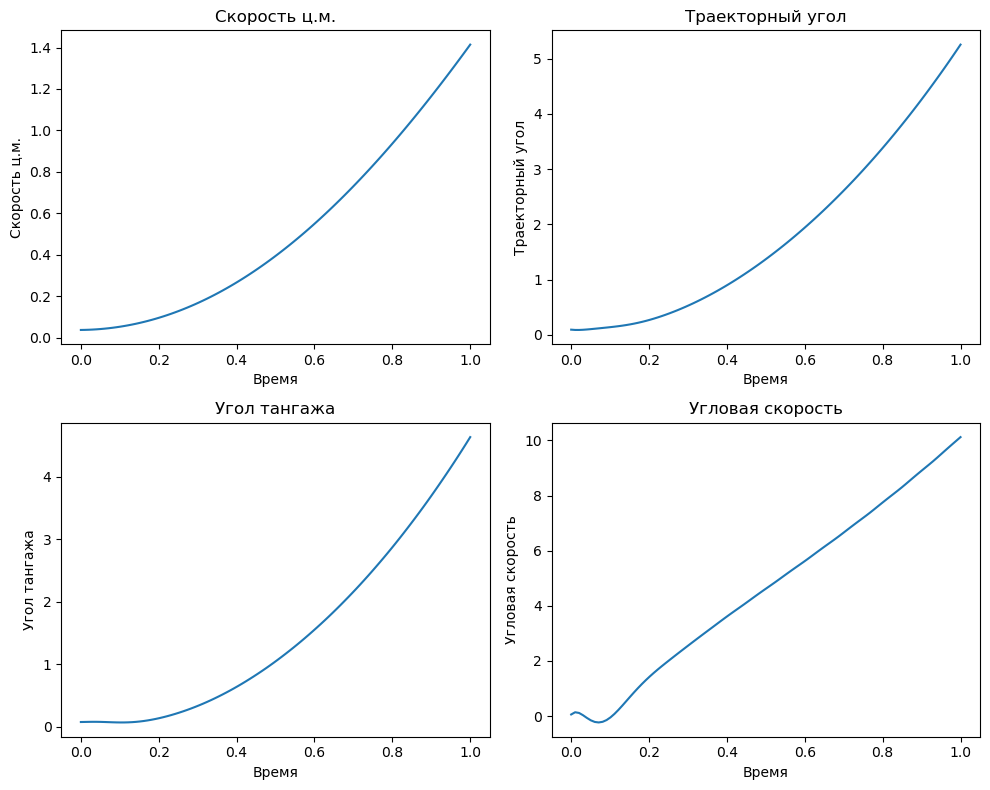

In [26]:
print(f'x0 = {x0}')

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(t_values, V_values4)
plt.xlabel('Время')
plt.ylabel('Скорость ц.м.')
plt.title('Скорость ц.м.')

plt.subplot(2, 2, 2)
plt.plot(t_values, theta_values4)
plt.xlabel('Время')
plt.ylabel('Траекторный угол')
plt.title('Траекторный угол')

plt.subplot(2, 2, 3)
plt.plot(t_values, phi_values4)
plt.xlabel('Время')
plt.ylabel('Угол тангажа')
plt.title('Угол тангажа')

plt.subplot(2, 2, 4)
plt.plot(t_values, Omega_values4)
plt.xlabel('Время')
plt.ylabel('Угловая скорость')
plt.title('Угловая скорость')

plt.tight_layout()
plt.show()

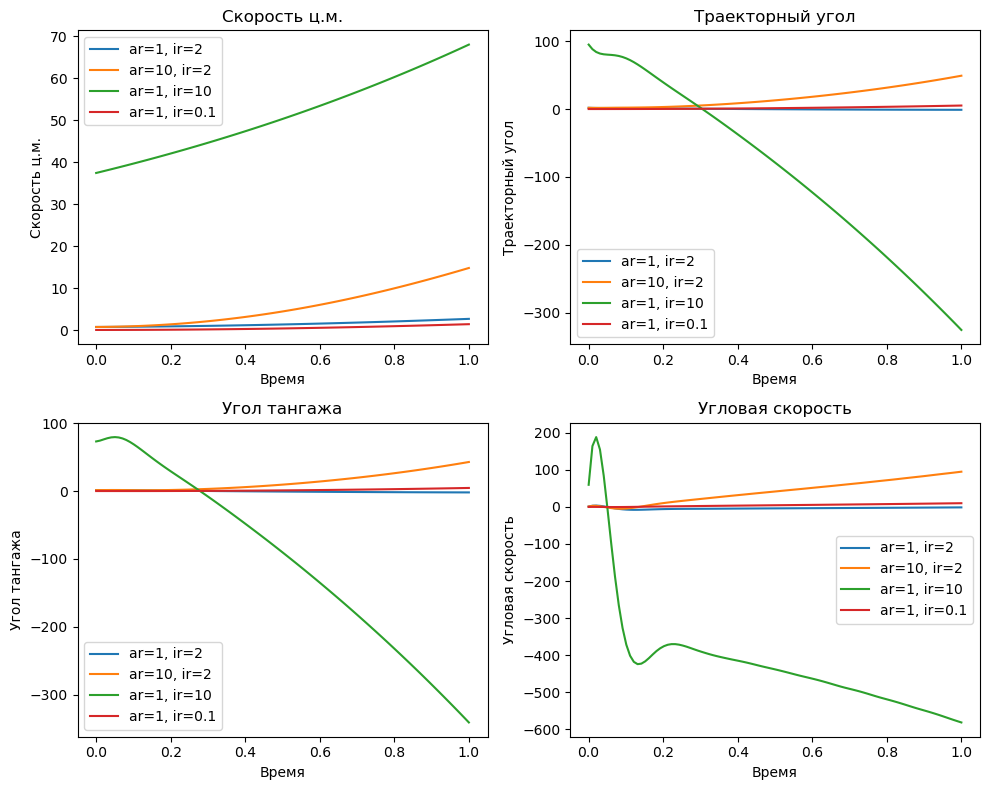

In [27]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(t_values, V_values1, label='ar=1, ir=2')
plt.plot(t_values, V_values2, label='ar=10, ir=2')
plt.plot(t_values, V_values3, label='ar=1, ir=10')
plt.plot(t_values, V_values4, label='ar=1, ir=0.1')
plt.xlabel('Время')
plt.ylabel('Скорость ц.м.')
plt.title('Скорость ц.м.')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(t_values, theta_values1, label='ar=1, ir=2')
plt.plot(t_values, theta_values2, label='ar=10, ir=2')
plt.plot(t_values, theta_values3, label='ar=1, ir=10')
plt.plot(t_values, theta_values4, label='ar=1, ir=0.1')
plt.xlabel('Время')
plt.ylabel('Траекторный угол')
plt.title('Траекторный угол')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(t_values, phi_values1, label='ar=1, ir=2')
plt.plot(t_values, phi_values2, label='ar=10, ir=2')
plt.plot(t_values, phi_values3, label='ar=1, ir=10')
plt.plot(t_values, phi_values4, label='ar=1, ir=0.1')
plt.xlabel('Время')
plt.ylabel('Угол тангажа')
plt.title('Угол тангажа')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(t_values, Omega_values1, label='ar=1, ir=2')
plt.plot(t_values, Omega_values2, label='ar=10, ir=2')
plt.plot(t_values, Omega_values3, label='ar=1, ir=10')
plt.plot(t_values, Omega_values4, label='ar=1, ir=0.1')
plt.xlabel('Время')
plt.ylabel('Угловая скорость')
plt.title('Угловая скорость')
plt.legend()

plt.tight_layout()
plt.show()

# Решение задачи Булгакова

In [28]:
np.random.seed(42)
def integrate_system_control(A, B, u, z0, tk):
#     T = np.linspace(0, tk, int(tk*10))
    
#     def right_side(z, t, A, B, u):
#         return A@z - B@u.get_control(t)
    
#      z = integrate.odeint(right_side, z0, T, args=(A, B, u))
    
    
    def right_side(t, state):
        control = u.get_control(t)
        
        return A@state - B@control
        
    t_start = 0
    dt = (tk - t_start) / 100
    t_span = (t_start, tk)
    
    solution = integrate.solve_ivp(right_side,
                         t_span,
                         z0,
                         t_eval=np.arange(t_start, tk, dt)
                        )
    # V_values, theta_values, phi_values, Omega_values = solution.y
    # t_values = np.linspace(0, t_end, len(V_values)) #solution.t
    
#     res = solution.y
#     res = res.reshape((-1, 4))
    
#     return res

    return solution.y

In [29]:
np.random.seed(42)
def integrate_system_disturbance(A, C, v, y0, tk):
#     T = np.linspace(0, tk, int(tk*10))
    
#     def right_side(y, t, A, C, v):
#         return A@y + C@v.get_disturbance(t)
    
#     y = integrate.odeint(right_side, y0, T, args=(A, C, v))
    
    def right_side(t, state):
        disturbance = v.get_disturbance(t)
        
        return A@state + C@disturbance
    
    t_start = 0
    dt = (tk - t_start) / 100
    t_span = (t_start, tk)
    
    solution = integrate.solve_ivp(right_side,
                         t_span,
                         y0,
                         t_eval=np.arange(t_start, tk, dt)
                        )
    # V_values, theta_values, phi_values, Omega_values = solution.y
    # t_values = np.linspace(0, t_end, len(V_values)) #solution.t

#     res = solution.y
#     res = res.reshape((-1, 4))
    
#     return res
    return solution.y

In [30]:
class Psi:
    def __init__(self, A, c,
                 tk
                ):
        self.A = A
        self.c = c
        self.tk = tk
    
    def exponential_matrix(self, matrix, t):
        
        # res = linalg.expm(matrix*t)
        # res = np.eye(matrix.shape[0]) + t*matrix + 0.5*(t**2)*(matrix@matrix) + (t**3)*(matrix@matrix)@matrix/6
        
        res = np.eye(matrix.shape[0])
        factorial = 1
        matrix_power_i = matrix
        
        for i in range(1, 7):
            res += (t**i) * matrix_power_i / factorial
            matrix_power_i = matrix_power_i @ matrix
            factorial *= i+1
            
        return res
    
    def func(self, t):
        exp_mat = self.exponential_matrix(self.A.T, self.tk - t)
        
        return np.dot(exp_mat, self.c)

In [31]:
class Control:
    def __init__(self, Psi, power_min, power_max, sigma_min, sigma_max, matrix_B):
        self.Psi = Psi
        self.power_min = power_min
        self.power_max = power_max
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.matrix_B = matrix_B
      
    
    def get_control(self, t):
        psi_t = self.Psi.func(t) 
        
        if psi_t@self.matrix_B[:, 0] < 0:
            power = self.power_max
        else:
            power = self.power_min
        
        if psi_t@self.matrix_B[:, 1] < 0:
            sigma = self.sigma_max
        else:
            sigma = self.sigma_min
            
        return np.array([power, sigma])

In [32]:
class Disturbance:
    def __init__(self, Psi, v1_min, v1_max, v2_min, v2_max, matrix_C):
        self.Psi = Psi
        self.v1_min = v1_min
        self.v1_max = v1_max
        self.v2_min = v2_min
        self.v2_max = v2_max
        self.matrix_C = matrix_C

    
    def get_disturbance(self, t):
        psi = self.Psi.func(t)
        
        if psi@matrix_C[:, 0] < 0:
            v1 = self.v1_max
        else:
            v1 = self.v1_min
        
        if psi@matrix_C[:, 1] < 0:
            v2 = self.v2_max
        else:
            v2 = self.v2_min
            
        return np.array([v1, v2])

In [33]:
def get_attainability_domains(tk, z0, y0, grid_c, matrix_A, matrix_B, matrix_C,
                              u1_min, u1_max, u2_min, u2_max, v1_min, v1_max, v2_min, v2_max):
    
    control_domain = []

    for vector_c in tqdm(grid_c):
        function_psi = Psi(matrix_A,
                       vector_c, 
                       tk
                      )

        function_control = Control(function_psi, power_min=u1_min, power_max=u1_max,
                                   sigma_min= u2_min, sigma_max=u2_max,
                                   matrix_B = matrix_B)
        z = integrate_system_control(matrix_A, matrix_B, function_control, z0, tk)
        control_domain.append(z[-1])

    control_domain = np.array(control_domain)


    disturbance_domain = []

    for vector_c in tqdm(grid_c):
        function_psi = Psi(matrix_A,
                       vector_c, 
                       tk
                      )

        function_disturbance = Disturbance(function_psi, v1_min= v1_min, v1_max=v1_max,
                                           v2_min= v2_min, v2_max=v2_max,
                                           matrix_C=matrix_C)
        y = integrate_system_disturbance(matrix_A, matrix_C, function_disturbance, y0, tk)
        disturbance_domain.append(y[-1])

    disturbance_domain = np.array(disturbance_domain)
    
    return control_domain, disturbance_domain

In [34]:
def find_minmax(control_domain, disturbance_domain):
    # поиск минимакса 

    list_y_max_distance = []
    list_max_distance = []

    for z in control_domain:

        max_distance = -np.inf
        y_max_distance = disturbance_domain[0]

        for y in disturbance_domain:
            distance = np.linalg.norm(y - z)

            if distance > max_distance:
                max_distance = distance
                y_max_distance = y

        list_y_max_distance.append(y_max_distance)
        list_max_distance.append(max_distance)

    idx_minmax = np.argmin(list_max_distance)

    minmax = list_max_distance[idx_minmax]

    saddle_point_minmax = np.array([control_domain[idx_minmax], list_y_max_distance[idx_minmax]])
    
    return minmax, saddle_point_minmax, idx_minmax

In [35]:
def find_maxmin(control_domain, disturbance_domain):
    # поиск максимина

    list_z_min_distance = []
    list_min_distance = []

    for y in disturbance_domain:

        min_distance = np.inf
        z_min_distance = control_domain[0]

        for z in control_domain:
            distance = np.linalg.norm(y - z)

            if distance < min_distance:
                min_distance = distance
                z_min_distance = z

        list_z_min_distance.append(z_min_distance)
        list_min_distance.append(min_distance)

    idx_maxmin = np.argmax(list_min_distance)

    maxmin = list_min_distance[idx_maxmin]

    saddle_point_maxmin = np.array([list_z_min_distance[idx_maxmin], disturbance_domain[idx_maxmin]])
    
    return maxmin, saddle_point_maxmin, idx_maxmin

In [63]:
tk = 1
z0 = np.array([0, 0, 0, 0])

np.random.seed(42)
init_ratio = 2
y0 = init_ratio * np.random.random(4)

grid_c = np.array([x / np.linalg.norm(x) for x in itertools.product(np.linspace(-1, 1, 6),
                                                                    np.linspace(-1, 1, 6),
                                                                    np.linspace(-1, 1, 6),
                                                                    np.linspace(-1, 1, 6))])    


list_all_disturbance = []
list_diff_disturbance = []
list_diff_trajectories_disturbance = []
list_diff_vector_c_disturbance = []
disturbance_domain = []

for vector_c in tqdm(grid_c):
    function_psi = Psi(matrix_A,
                   vector_c, 
                   tk
                  )

    function_disturbance = Disturbance(function_psi, v1_min= -0.2, v1_max=0.2,
                                       v2_min= -0.2, v2_max=0.2,
                                       matrix_C=matrix_C)
    values_disturbance = [function_disturbance.get_disturbance(t_cur).tolist() for t_cur in np.linspace(0, tk, int(tk*10))]

    list_all_disturbance.append(values_disturbance)
    
    if values_disturbance not in list_diff_disturbance:
        list_diff_disturbance.append(values_disturbance)
        list_diff_vector_c_disturbance.append(vector_c)
    
    
    y = integrate_system_disturbance(matrix_A, matrix_C, function_disturbance, y0, tk)
    disturbance_domain.append(y[:, -1])
    y = y.tolist()
    if y not in list_diff_trajectories_disturbance:
        list_diff_trajectories_disturbance.append(y)
    

disturbance_domain = np.array(disturbance_domain)
list_diff_disturbance = np.array(list_diff_disturbance)
list_diff_trajectories_disturbance = np.array(list_diff_trajectories_disturbance)
list_diff_vector_c_disturbance = np.array(list_diff_vector_c_disturbance)
list_all_disturbance = np.array(list_all_disturbance)


list_all_control = []
list_diff_control = []
list_diff_trajectories_control = []
list_diff_vector_c_control = []
control_domain = []

for vector_c in tqdm(grid_c):
    function_psi = Psi(matrix_A,
                   vector_c, 
                   tk
                  )

    function_control = Control(function_psi, power_min=0, power_max=0.15, sigma_min= -0.25, sigma_max=0.25,
                                       matrix_B=matrix_B)
    values_control = [function_control.get_control(t_cur).tolist() for t_cur in np.linspace(0, tk, int(tk*10))]

    list_all_control.append(values_control)
    
    if values_control not in list_diff_control:
        list_diff_control.append(values_control)
        list_diff_vector_c_control.append(vector_c)
    
    
    z = integrate_system_control(matrix_A, matrix_B, function_control, z0, tk)
    control_domain.append(z[:, -1])
    z = z.tolist()
    if z not in list_diff_trajectories_control:
        list_diff_trajectories_control.append(z)
    

control_domain = np.array(control_domain)
list_diff_control = np.array(list_diff_control)
list_diff_trajectories_control = np.array(list_diff_trajectories_control)
list_diff_vector_c_control = np.array(list_diff_vector_c_control)
list_all_control = np.array(list_all_control)

100%|██████████████████████████████████████████████████████████████████████████████| 1296/1296 [01:10<00:00, 18.32it/s]


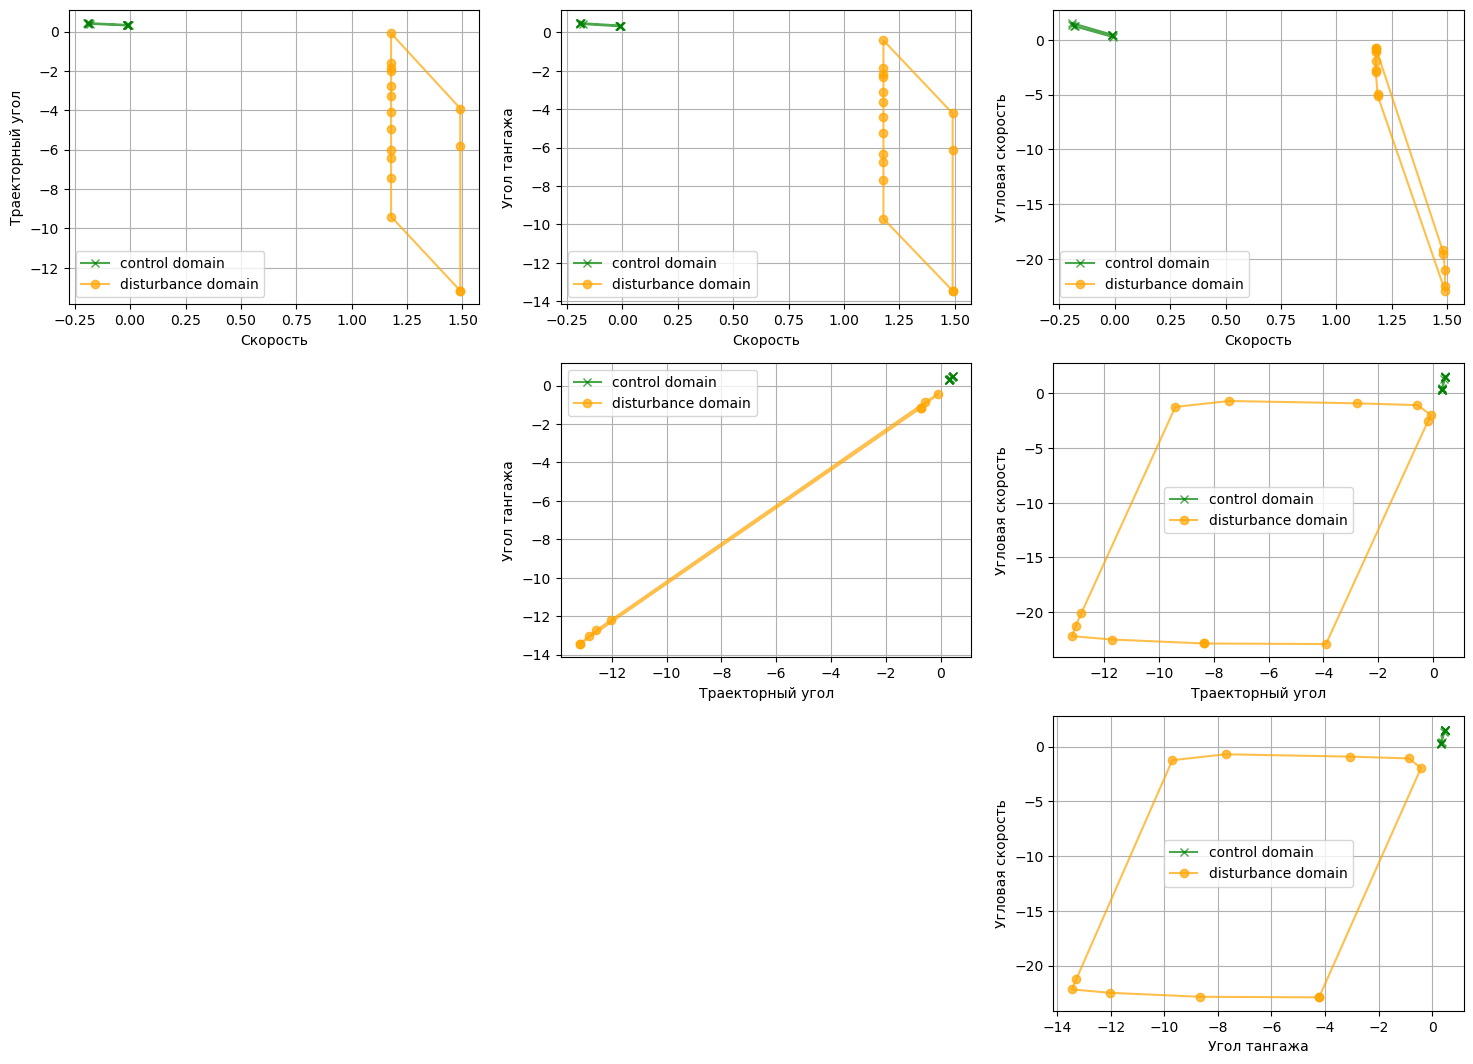

In [64]:
fig = plt.figure(figsize=(18, 13))

alpha=0.7

control_hull_01 = ConvexHull(control_domain[:, (0, 1)])
disturb_hull_01 = ConvexHull(disturbance_domain[:, (0, 1)])

control_hull_01_idx = control_hull_01.vertices.tolist() + [control_hull_01.vertices[0]]
disturb_hull_01_idx = disturb_hull_01.vertices.tolist() + [disturb_hull_01.vertices[0]]

fig.add_subplot(3, 3, 1)

plt.plot(control_domain[control_hull_01_idx, 0], control_domain[control_hull_01_idx, 1],
         #'b--',
         label="control domain", color="green", marker="x",
         alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_01_idx, 0], disturbance_domain[disturb_hull_01_idx, 1], label="disturbance domain", color="orange", marker="o", alpha=alpha)

# plt.plot(control_domain[:, 0], control_domain[:, 1], label="control domain", color="green", marker="x", alpha=alpha)
# plt.plot(disturbance_domain[:, 0], disturbance_domain[:, 1], label="disturbance domain", color="orange", marker="o", alpha=alpha)
plt.grid()
plt.xlabel('Скорость')
plt.ylabel('Траекторный угол')
plt.legend()


control_hull_02 = ConvexHull(control_domain[:, (0, 2)])
disturb_hull_02 = ConvexHull(disturbance_domain[:, (0, 2)])

control_hull_02_idx = control_hull_02.vertices.tolist() + [control_hull_02.vertices[0]]
disturb_hull_02_idx = disturb_hull_02.vertices.tolist() + [disturb_hull_02.vertices[0]]

fig.add_subplot(3, 3, 2)

plt.plot(control_domain[control_hull_02_idx, 0], control_domain[control_hull_02_idx, 2], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_02_idx, 0], disturbance_domain[disturb_hull_02_idx, 2], label="disturbance domain", color="orange", marker="o", alpha=alpha)

# fig.add_subplot(3, 3, 2)
# plt.plot(control_domain[:, 0], control_domain[:, 2], label="control domain", color="green", marker="x", alpha=alpha)
# plt.plot(disturbance_domain[:, 0], disturbance_domain[:, 2], label="disturbance domain", color="orange", marker="o", alpha=alpha)
plt.grid()
plt.xlabel('Скорость')
plt.ylabel('Угол тангажа')
plt.legend()



control_hull_03 = ConvexHull(control_domain[:, (0, 3)])
disturb_hull_03 = ConvexHull(disturbance_domain[:, (0, 3)])

control_hull_03_idx = control_hull_03.vertices.tolist() + [control_hull_03.vertices[0]]
disturb_hull_03_idx = disturb_hull_03.vertices.tolist() + [disturb_hull_03.vertices[0]]

fig.add_subplot(3, 3, 3)

plt.plot(control_domain[control_hull_03_idx, 0], control_domain[control_hull_03_idx, 3], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_03_idx, 0], disturbance_domain[disturb_hull_03_idx, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)

# fig.add_subplot(3, 3, 3)
# plt.plot(control_domain[:, 0], control_domain[:, 3], label="control domain", color="green", marker="x", alpha=alpha)
# plt.plot(disturbance_domain[:, 0], disturbance_domain[:, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)
plt.grid()
plt.xlabel('Скорость')
plt.ylabel('Угловая скорость')
plt.legend()



control_hull_12 = ConvexHull(control_domain[:, (1, 2)])
disturb_hull_12 = ConvexHull(disturbance_domain[:, (1, 2)])

control_hull_12_idx = control_hull_12.vertices.tolist() + [control_hull_12.vertices[0]]
disturb_hull_12_idx = disturb_hull_12.vertices.tolist() + [disturb_hull_12.vertices[0]]

fig.add_subplot(3, 3, 5)

plt.plot(control_domain[control_hull_12_idx, 1], control_domain[control_hull_12_idx, 2], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_12_idx, 1], disturbance_domain[disturb_hull_12_idx, 2], label="disturbance domain", color="orange", marker="o", alpha=alpha)

# fig.add_subplot(3, 3, 5)
# plt.plot(control_domain[:, 1], control_domain[:, 2], label="control domain", color="green", marker="x", alpha=alpha)
# plt.plot(disturbance_domain[:, 1], disturbance_domain[:, 2], label="disturbance domain", color="orange", marker="o", alpha=alpha)
plt.grid()
plt.xlabel('Траекторный угол')
plt.ylabel('Угол тангажа')
plt.legend()


control_hull_13 = ConvexHull(control_domain[:, (1, 3)])
disturb_hull_13 = ConvexHull(disturbance_domain[:, (1, 3)])

control_hull_13_idx = control_hull_13.vertices.tolist() + [control_hull_13.vertices[0]]
disturb_hull_13_idx = disturb_hull_13.vertices.tolist() + [disturb_hull_13.vertices[0]]

fig.add_subplot(3, 3, 6)

plt.plot(control_domain[control_hull_13_idx, 1], control_domain[control_hull_13_idx, 3],
         #'b-',
         label="control domain", color="green", marker="x",
         alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_13_idx, 1], disturbance_domain[disturb_hull_13_idx, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)

# fig.add_subplot(3, 3, 6)
# plt.plot(control_domain[:, 1], control_domain[:, 3], label="control domain", color="green", marker="x", alpha=alpha)
# plt.plot(disturbance_domain[:, 1], disturbance_domain[:, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)
plt.grid()
plt.xlabel('Траекторный угол')
plt.ylabel('Угловая скорость')
plt.legend()



control_hull_23 = ConvexHull(control_domain[:, (2, 3)])
disturb_hull_23 = ConvexHull(disturbance_domain[:, (2, 3)])

control_hull_23_idx = control_hull_23.vertices.tolist() + [control_hull_23.vertices[0]]
disturb_hull_23_idx = disturb_hull_23.vertices.tolist() + [disturb_hull_23.vertices[0]]

fig.add_subplot(3, 3, 9)

plt.plot(control_domain[control_hull_23_idx, 2], control_domain[control_hull_23_idx, 3], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_23_idx, 2], disturbance_domain[disturb_hull_23_idx, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)

# fig.add_subplot(3, 3, 9)
# plt.plot(control_domain[:, 2], control_domain[:, 3], label="control domain", color="green", marker="x", alpha=alpha)
# plt.plot(disturbance_domain[:, 2], disturbance_domain[:, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)
plt.grid()
plt.xlabel('Угол тангажа')
plt.ylabel('Угловая скорость')
plt.legend()

plt.show()

In [65]:
minmax, saddle_point_minmax, idx_minmax = find_minmax(control_domain, disturbance_domain)
maxmin, saddle_point_maxmin, idx_maxmin = find_maxmin(control_domain, disturbance_domain)

In [66]:
print(minmax, maxmin)
print(idx_minmax, idx_maxmin)
print(saddle_point_maxmin)

29.618130075396962 29.618130075396962
1083 183
[[-7.26245633e-03  3.15714737e-01  3.16331779e-01  2.60928601e-01]
 [ 1.49021455e+00 -1.31685139e+01 -1.34501657e+01 -2.21812263e+01]]


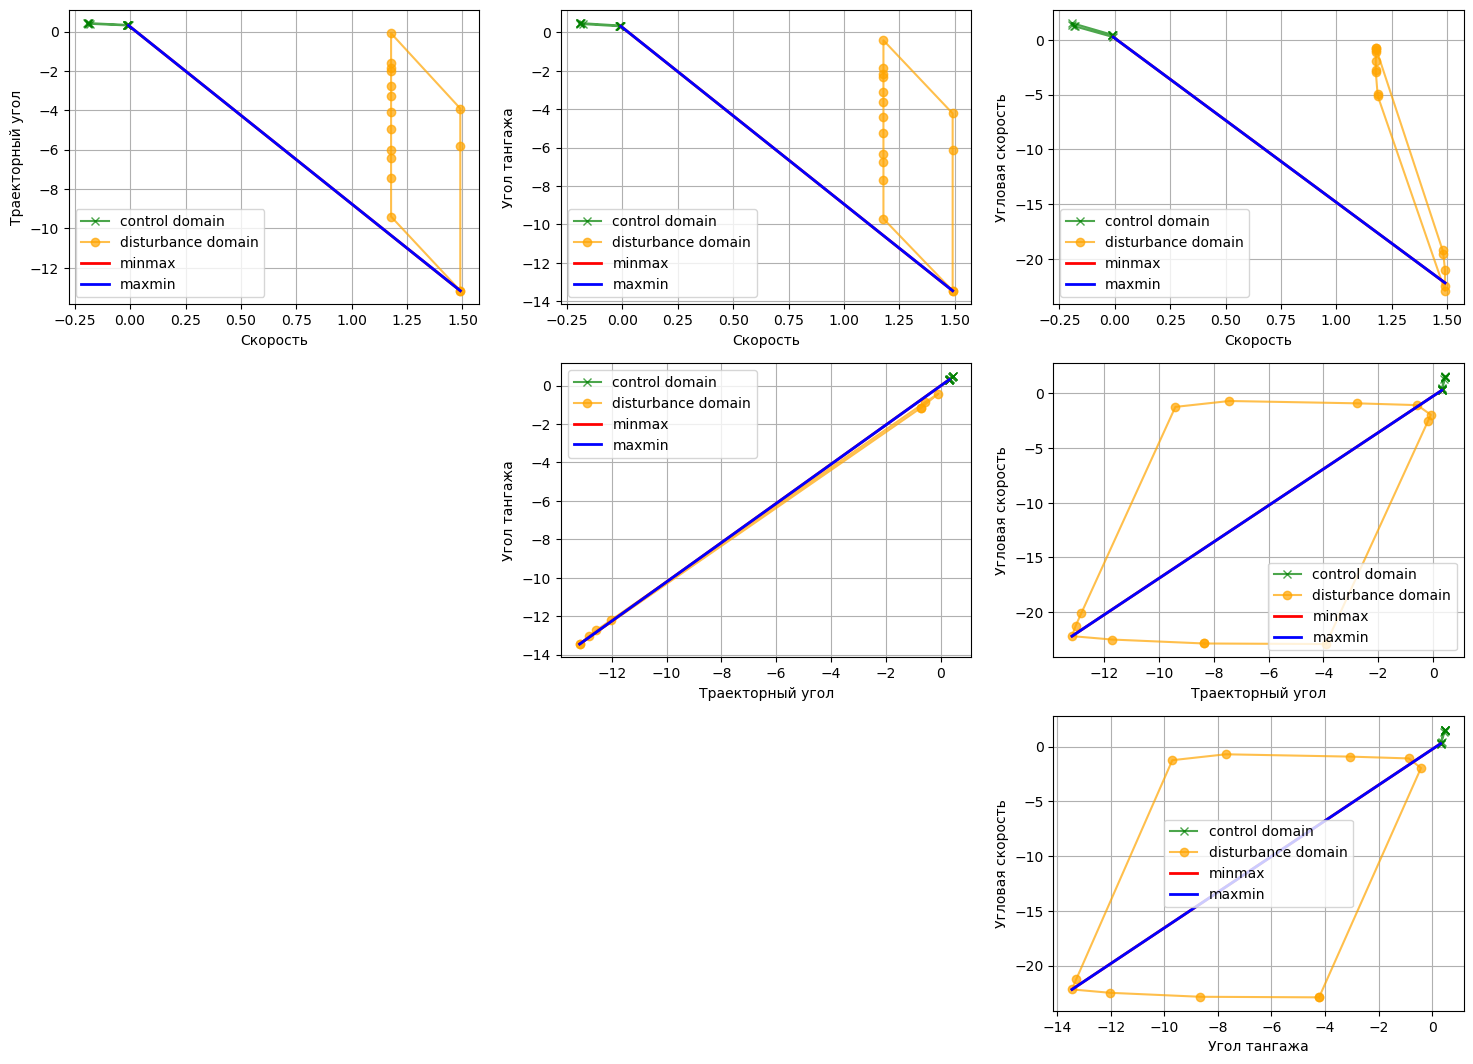

In [67]:
fig = plt.figure(figsize=(18, 13))

alpha=0.7

control_hull_01 = ConvexHull(control_domain[:, (0, 1)])
disturb_hull_01 = ConvexHull(disturbance_domain[:, (0, 1)])

control_hull_01_idx = control_hull_01.vertices.tolist() + [control_hull_01.vertices[0]]
disturb_hull_01_idx = disturb_hull_01.vertices.tolist() + [disturb_hull_01.vertices[0]]

fig.add_subplot(3, 3, 1)

plt.plot(control_domain[control_hull_01_idx, 0], control_domain[control_hull_01_idx, 1], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_01_idx, 0], disturbance_domain[disturb_hull_01_idx, 1], label="disturbance domain", color="orange", marker="o", alpha=alpha)

plt.plot(saddle_point_minmax[0][0], saddle_point_minmax[0][1], color="red")
plt.plot(saddle_point_minmax[1][0], saddle_point_minmax[1][1], color="red")
plt.plot([saddle_point_minmax[0][0], saddle_point_minmax[1][0]],
         [saddle_point_minmax[0][1], saddle_point_minmax[1][1]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][0], saddle_point_maxmin[0][1], color="blue")
plt.plot(saddle_point_maxmin[1][0], saddle_point_maxmin[1][1], color="blue")
plt.plot([saddle_point_maxmin[0][0], saddle_point_maxmin[1][0]],
         [saddle_point_maxmin[0][1], saddle_point_maxmin[1][1]],
         color="blue", label="maxmin", linewidth=2)

plt.grid()
plt.xlabel('Скорость')
plt.ylabel('Траекторный угол')
plt.legend()


control_hull_02 = ConvexHull(control_domain[:, (0, 2)])
disturb_hull_02 = ConvexHull(disturbance_domain[:, (0, 2)])

control_hull_02_idx = control_hull_02.vertices.tolist() + [control_hull_02.vertices[0]]
disturb_hull_02_idx = disturb_hull_02.vertices.tolist() + [disturb_hull_02.vertices[0]]

fig.add_subplot(3, 3, 2)

plt.plot(control_domain[control_hull_02_idx, 0], control_domain[control_hull_02_idx, 2], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_02_idx, 0], disturbance_domain[disturb_hull_02_idx, 2], label="disturbance domain", color="orange", marker="o", alpha=alpha)

plt.plot(saddle_point_minmax[0][0], saddle_point_minmax[0][2], color="red")
plt.plot(saddle_point_minmax[1][0], saddle_point_minmax[1][2], color="red")
plt.plot([saddle_point_minmax[0][0], saddle_point_minmax[1][0]],
         [saddle_point_minmax[0][2], saddle_point_minmax[1][2]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][0], saddle_point_maxmin[0][2], color="blue")
plt.plot(saddle_point_maxmin[1][0], saddle_point_maxmin[1][2], color="blue")
plt.plot([saddle_point_maxmin[0][0], saddle_point_maxmin[1][0]],
         [saddle_point_maxmin[0][2], saddle_point_maxmin[1][2]],
         color="blue", label="maxmin", linewidth=2)

plt.grid()
plt.xlabel('Скорость')
plt.ylabel('Угол тангажа')
plt.legend()



control_hull_03 = ConvexHull(control_domain[:, (0, 3)])
disturb_hull_03 = ConvexHull(disturbance_domain[:, (0, 3)])

control_hull_03_idx = control_hull_03.vertices.tolist() + [control_hull_03.vertices[0]]
disturb_hull_03_idx = disturb_hull_03.vertices.tolist() + [disturb_hull_03.vertices[0]]

fig.add_subplot(3, 3, 3)

plt.plot(control_domain[control_hull_03_idx, 0], control_domain[control_hull_03_idx, 3], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_03_idx, 0], disturbance_domain[disturb_hull_03_idx, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)

plt.plot(saddle_point_minmax[0][0], saddle_point_minmax[0][3], color="red")
plt.plot(saddle_point_minmax[1][0], saddle_point_minmax[1][3], color="red")
plt.plot([saddle_point_minmax[0][0], saddle_point_minmax[1][0]],
         [saddle_point_minmax[0][3], saddle_point_minmax[1][3]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][0], saddle_point_maxmin[0][3], color="blue")
plt.plot(saddle_point_maxmin[1][0], saddle_point_maxmin[1][3], color="blue")
plt.plot([saddle_point_maxmin[0][0], saddle_point_maxmin[1][0]],
         [saddle_point_maxmin[0][3], saddle_point_maxmin[1][3]],
         color="blue", label="maxmin", linewidth=2)

plt.grid()
plt.xlabel('Скорость')
plt.ylabel('Угловая скорость')
plt.legend()



control_hull_12 = ConvexHull(control_domain[:, (1, 2)])
disturb_hull_12 = ConvexHull(disturbance_domain[:, (1, 2)])

control_hull_12_idx = control_hull_12.vertices.tolist() + [control_hull_12.vertices[0]]
disturb_hull_12_idx = disturb_hull_12.vertices.tolist() + [disturb_hull_12.vertices[0]]

fig.add_subplot(3, 3, 5)

plt.plot(control_domain[control_hull_12_idx, 1], control_domain[control_hull_12_idx, 2], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_12_idx, 1], disturbance_domain[disturb_hull_12_idx, 2], label="disturbance domain", color="orange", marker="o", alpha=alpha)

plt.plot(saddle_point_minmax[0][1], saddle_point_minmax[0][2], color="red")
plt.plot(saddle_point_minmax[1][1], saddle_point_minmax[1][2], color="red")
plt.plot([saddle_point_minmax[0][1], saddle_point_minmax[1][1]],
         [saddle_point_minmax[0][2], saddle_point_minmax[1][2]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][1], saddle_point_maxmin[0][2], color="blue")
plt.plot(saddle_point_maxmin[1][1], saddle_point_maxmin[1][2], color="blue")
plt.plot([saddle_point_maxmin[0][1], saddle_point_maxmin[1][1]],
         [saddle_point_maxmin[0][2], saddle_point_maxmin[1][2]],
         color="blue", label="maxmin", linewidth=2)

plt.grid()
plt.xlabel('Траекторный угол')
plt.ylabel('Угол тангажа')
plt.legend()


control_hull_13 = ConvexHull(control_domain[:, (1, 3)])
disturb_hull_13 = ConvexHull(disturbance_domain[:, (1, 3)])

control_hull_13_idx = control_hull_13.vertices.tolist() + [control_hull_13.vertices[0]]
disturb_hull_13_idx = disturb_hull_13.vertices.tolist() + [disturb_hull_13.vertices[0]]

fig.add_subplot(3, 3, 6)

plt.plot(control_domain[control_hull_13_idx, 1], control_domain[control_hull_13_idx, 3], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_13_idx, 1], disturbance_domain[disturb_hull_13_idx, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)

plt.plot(saddle_point_minmax[0][1], saddle_point_minmax[0][3], color="red")
plt.plot(saddle_point_minmax[1][1], saddle_point_minmax[1][3], color="red")
plt.plot([saddle_point_minmax[0][1], saddle_point_minmax[1][1]],
         [saddle_point_minmax[0][3], saddle_point_minmax[1][3]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][1], saddle_point_maxmin[0][3], color="blue")
plt.plot(saddle_point_maxmin[1][1], saddle_point_maxmin[1][3], color="blue")
plt.plot([saddle_point_maxmin[0][1], saddle_point_maxmin[1][1]],
         [saddle_point_maxmin[0][3], saddle_point_maxmin[1][3]],
         color="blue", label="maxmin", linewidth=2)

plt.grid()
plt.xlabel('Траекторный угол')
plt.ylabel('Угловая скорость')
plt.legend()



control_hull_23 = ConvexHull(control_domain[:, (2, 3)])
disturb_hull_23 = ConvexHull(disturbance_domain[:, (2, 3)])

control_hull_23_idx = control_hull_23.vertices.tolist() + [control_hull_23.vertices[0]]
disturb_hull_23_idx = disturb_hull_23.vertices.tolist() + [disturb_hull_23.vertices[0]]

fig.add_subplot(3, 3, 9)

plt.plot(control_domain[control_hull_23_idx, 2], control_domain[control_hull_23_idx, 3], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_23_idx, 2], disturbance_domain[disturb_hull_23_idx, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)

plt.plot(saddle_point_minmax[0][2], saddle_point_minmax[0][3], color="red")
plt.plot(saddle_point_minmax[1][2], saddle_point_minmax[1][3], color="red")
plt.plot([saddle_point_minmax[0][2], saddle_point_minmax[1][2]],
         [saddle_point_minmax[0][3], saddle_point_minmax[1][3]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][2], saddle_point_maxmin[0][3], color="blue")
plt.plot(saddle_point_maxmin[1][2], saddle_point_maxmin[1][3], color="blue")
plt.plot([saddle_point_maxmin[0][2], saddle_point_maxmin[1][2]],
         [saddle_point_maxmin[0][3], saddle_point_maxmin[1][3]],
         color="blue", label="maxmin", linewidth=2)

plt.grid()
plt.xlabel('Угол тангажа')
plt.ylabel('Угловая скорость')
plt.legend()

plt.show()

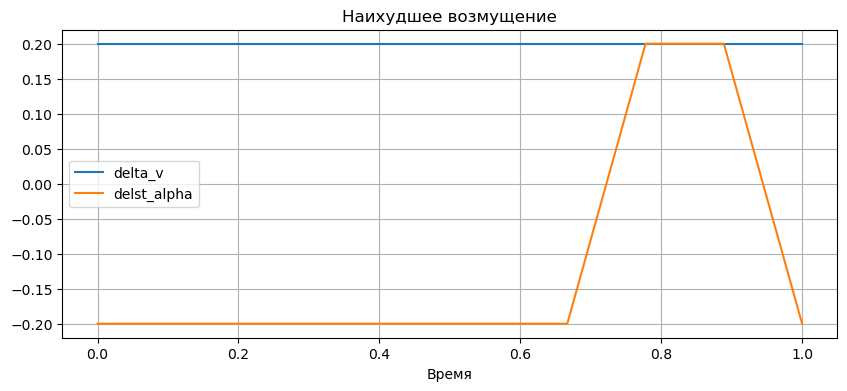

In [68]:
plt.figure(figsize=(10,4))
plt.plot(np.linspace(0, tk, int(tk*10)), list_all_disturbance[idx_maxmin][:, 0], label="delta_v")
plt.plot(np.linspace(0, tk, int(tk*10)), list_all_disturbance[idx_maxmin][:, 1], label="delst_alpha")
plt.grid()
plt.legend()
plt.title('Наихудшее возмущение')
plt.xlabel('Время')
plt.show()

In [69]:
tk = 1
z0 = np.array([0, 0, 0, 0])

np.random.seed(42)
init_ratio = 10
y0 = init_ratio * np.random.random(4)

grid_c = np.array([x / np.linalg.norm(x) for x in itertools.product(np.linspace(-1, 1, 6),
                                                                    np.linspace(-1, 1, 6),
                                                                    np.linspace(-1, 1, 6),
                                                                    np.linspace(-1, 1, 6))])    


list_all_disturbance = []
list_diff_disturbance = []
list_diff_trajectories_disturbance = []
list_diff_vector_c_disturbance = []
disturbance_domain = []

for vector_c in tqdm(grid_c):
    function_psi = Psi(matrix_A,
                   vector_c, 
                   tk
                  )

    function_disturbance = Disturbance(function_psi, v1_min= -0.2, v1_max=0.2,
                                       v2_min= -0.2, v2_max=0.2,
                                       matrix_C=matrix_C)
    values_disturbance = [function_disturbance.get_disturbance(t_cur).tolist() for t_cur in np.linspace(0, tk, int(tk*10))]

    list_all_disturbance.append(values_disturbance)
    
    if values_disturbance not in list_diff_disturbance:
        list_diff_disturbance.append(values_disturbance)
        list_diff_vector_c_disturbance.append(vector_c)
    
    
    y = integrate_system_disturbance(matrix_A, matrix_C, function_disturbance, y0, tk)
    disturbance_domain.append(y[:, -1])
    y = y.tolist()
    if y not in list_diff_trajectories_disturbance:
        list_diff_trajectories_disturbance.append(y)
    

disturbance_domain = np.array(disturbance_domain)
list_diff_disturbance = np.array(list_diff_disturbance)
list_diff_trajectories_disturbance = np.array(list_diff_trajectories_disturbance)
list_diff_vector_c_disturbance = np.array(list_diff_vector_c_disturbance)
list_all_disturbance = np.array(list_all_disturbance)


list_all_control = []
list_diff_control = []
list_diff_trajectories_control = []
list_diff_vector_c_control = []
control_domain = []

for vector_c in tqdm(grid_c):
    function_psi = Psi(matrix_A,
                   vector_c, 
                   tk
                  )

    function_control = Control(function_psi, power_min=0, power_max=0.15, sigma_min= -0.25, sigma_max=0.25,
                                       matrix_B=matrix_B)
    values_control = [function_control.get_control(t_cur).tolist() for t_cur in np.linspace(0, tk, int(tk*10))]

    list_all_control.append(values_control)
    
    if values_control not in list_diff_control:
        list_diff_control.append(values_control)
        list_diff_vector_c_control.append(vector_c)
    
    
    z = integrate_system_control(matrix_A, matrix_B, function_control, z0, tk)
    control_domain.append(z[:, -1])
    z = z.tolist()
    if z not in list_diff_trajectories_control:
        list_diff_trajectories_control.append(z)
    

control_domain = np.array(control_domain)
list_diff_control = np.array(list_diff_control)
list_diff_trajectories_control = np.array(list_diff_trajectories_control)
list_diff_vector_c_control = np.array(list_diff_vector_c_control)
list_all_control = np.array(list_all_control)

100%|██████████████████████████████████████████████████████████████████████████████| 1296/1296 [01:21<00:00, 15.96it/s]


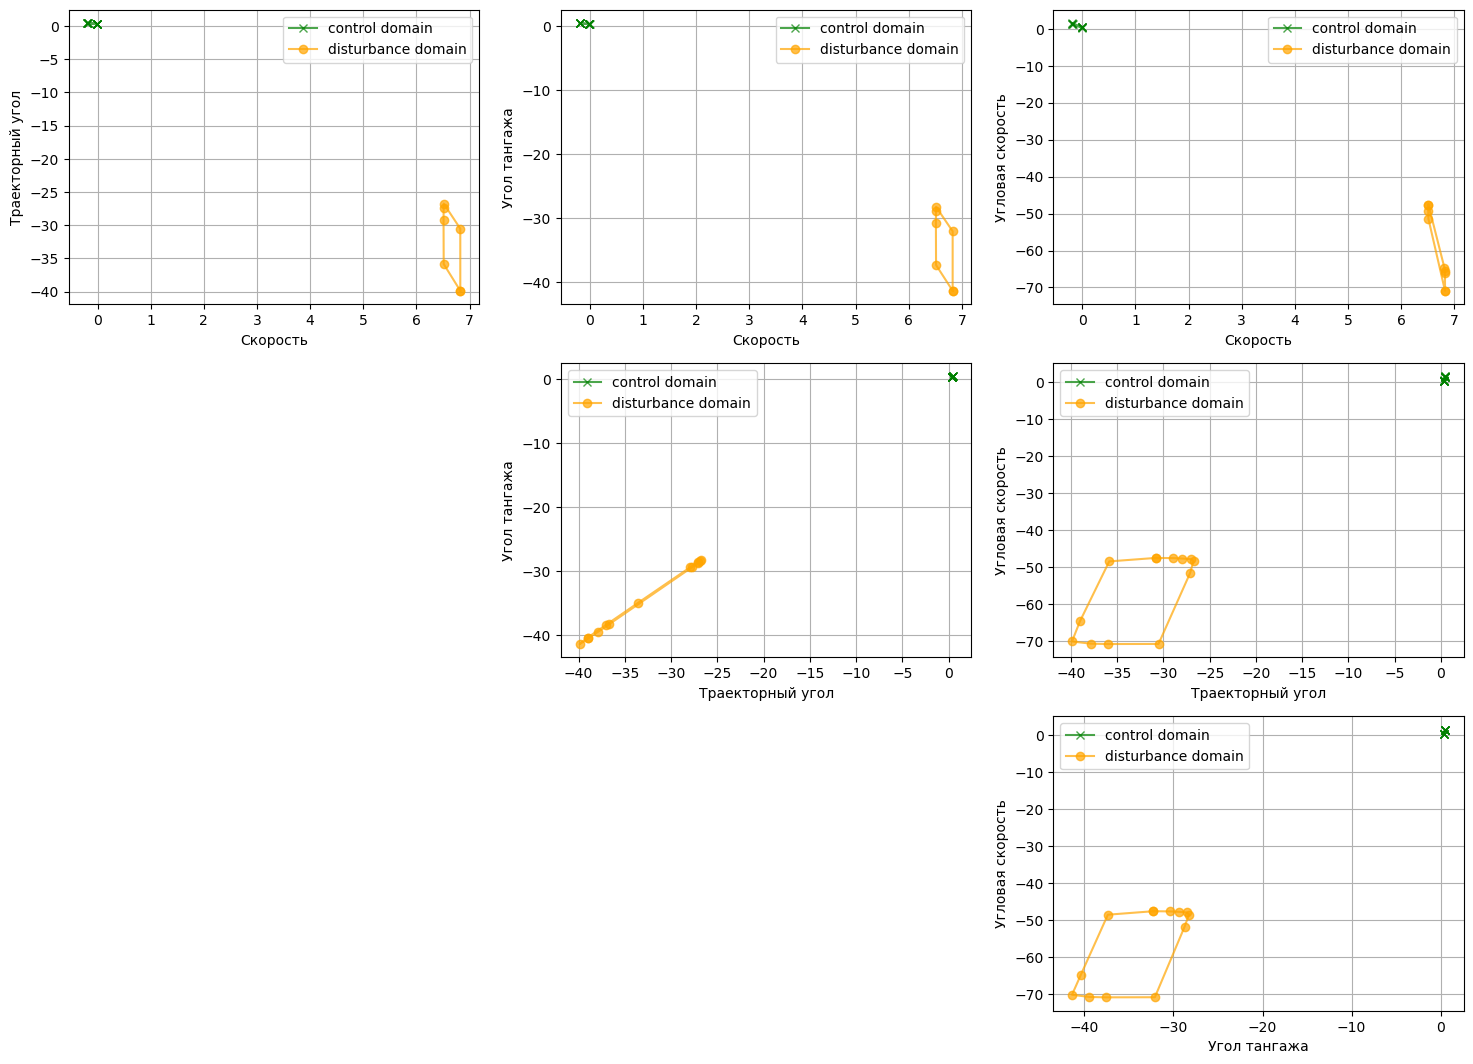

In [70]:
fig = plt.figure(figsize=(18, 13))

alpha=0.7

control_hull_01 = ConvexHull(control_domain[:, (0, 1)])
disturb_hull_01 = ConvexHull(disturbance_domain[:, (0, 1)])

control_hull_01_idx = control_hull_01.vertices.tolist() + [control_hull_01.vertices[0]]
disturb_hull_01_idx = disturb_hull_01.vertices.tolist() + [disturb_hull_01.vertices[0]]

fig.add_subplot(3, 3, 1)

plt.plot(control_domain[control_hull_01_idx, 0], control_domain[control_hull_01_idx, 1],
         #'b--',
         label="control domain", color="green", marker="x",
         alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_01_idx, 0], disturbance_domain[disturb_hull_01_idx, 1], label="disturbance domain", color="orange", marker="o", alpha=alpha)

# plt.plot(control_domain[:, 0], control_domain[:, 1], label="control domain", color="green", marker="x", alpha=alpha)
# plt.plot(disturbance_domain[:, 0], disturbance_domain[:, 1], label="disturbance domain", color="orange", marker="o", alpha=alpha)
plt.grid()
plt.xlabel('Скорость')
plt.ylabel('Траекторный угол')
plt.legend()


control_hull_02 = ConvexHull(control_domain[:, (0, 2)])
disturb_hull_02 = ConvexHull(disturbance_domain[:, (0, 2)])

control_hull_02_idx = control_hull_02.vertices.tolist() + [control_hull_02.vertices[0]]
disturb_hull_02_idx = disturb_hull_02.vertices.tolist() + [disturb_hull_02.vertices[0]]

fig.add_subplot(3, 3, 2)

plt.plot(control_domain[control_hull_02_idx, 0], control_domain[control_hull_02_idx, 2], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_02_idx, 0], disturbance_domain[disturb_hull_02_idx, 2], label="disturbance domain", color="orange", marker="o", alpha=alpha)

# fig.add_subplot(3, 3, 2)
# plt.plot(control_domain[:, 0], control_domain[:, 2], label="control domain", color="green", marker="x", alpha=alpha)
# plt.plot(disturbance_domain[:, 0], disturbance_domain[:, 2], label="disturbance domain", color="orange", marker="o", alpha=alpha)
plt.grid()
plt.xlabel('Скорость')
plt.ylabel('Угол тангажа')
plt.legend()



control_hull_03 = ConvexHull(control_domain[:, (0, 3)])
disturb_hull_03 = ConvexHull(disturbance_domain[:, (0, 3)])

control_hull_03_idx = control_hull_03.vertices.tolist() + [control_hull_03.vertices[0]]
disturb_hull_03_idx = disturb_hull_03.vertices.tolist() + [disturb_hull_03.vertices[0]]

fig.add_subplot(3, 3, 3)

plt.plot(control_domain[control_hull_03_idx, 0], control_domain[control_hull_03_idx, 3], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_03_idx, 0], disturbance_domain[disturb_hull_03_idx, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)

# fig.add_subplot(3, 3, 3)
# plt.plot(control_domain[:, 0], control_domain[:, 3], label="control domain", color="green", marker="x", alpha=alpha)
# plt.plot(disturbance_domain[:, 0], disturbance_domain[:, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)
plt.grid()
plt.xlabel('Скорость')
plt.ylabel('Угловая скорость')
plt.legend()



control_hull_12 = ConvexHull(control_domain[:, (1, 2)])
disturb_hull_12 = ConvexHull(disturbance_domain[:, (1, 2)])

control_hull_12_idx = control_hull_12.vertices.tolist() + [control_hull_12.vertices[0]]
disturb_hull_12_idx = disturb_hull_12.vertices.tolist() + [disturb_hull_12.vertices[0]]

fig.add_subplot(3, 3, 5)

plt.plot(control_domain[control_hull_12_idx, 1], control_domain[control_hull_12_idx, 2], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_12_idx, 1], disturbance_domain[disturb_hull_12_idx, 2], label="disturbance domain", color="orange", marker="o", alpha=alpha)

# fig.add_subplot(3, 3, 5)
# plt.plot(control_domain[:, 1], control_domain[:, 2], label="control domain", color="green", marker="x", alpha=alpha)
# plt.plot(disturbance_domain[:, 1], disturbance_domain[:, 2], label="disturbance domain", color="orange", marker="o", alpha=alpha)
plt.grid()
plt.xlabel('Траекторный угол')
plt.ylabel('Угол тангажа')
plt.legend()


control_hull_13 = ConvexHull(control_domain[:, (1, 3)])
disturb_hull_13 = ConvexHull(disturbance_domain[:, (1, 3)])

control_hull_13_idx = control_hull_13.vertices.tolist() + [control_hull_13.vertices[0]]
disturb_hull_13_idx = disturb_hull_13.vertices.tolist() + [disturb_hull_13.vertices[0]]

fig.add_subplot(3, 3, 6)

plt.plot(control_domain[control_hull_13_idx, 1], control_domain[control_hull_13_idx, 3],
         #'b-',
         label="control domain", color="green", marker="x",
         alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_13_idx, 1], disturbance_domain[disturb_hull_13_idx, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)

# fig.add_subplot(3, 3, 6)
# plt.plot(control_domain[:, 1], control_domain[:, 3], label="control domain", color="green", marker="x", alpha=alpha)
# plt.plot(disturbance_domain[:, 1], disturbance_domain[:, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)
plt.grid()
plt.xlabel('Траекторный угол')
plt.ylabel('Угловая скорость')
plt.legend()



control_hull_23 = ConvexHull(control_domain[:, (2, 3)])
disturb_hull_23 = ConvexHull(disturbance_domain[:, (2, 3)])

control_hull_23_idx = control_hull_23.vertices.tolist() + [control_hull_23.vertices[0]]
disturb_hull_23_idx = disturb_hull_23.vertices.tolist() + [disturb_hull_23.vertices[0]]

fig.add_subplot(3, 3, 9)

plt.plot(control_domain[control_hull_23_idx, 2], control_domain[control_hull_23_idx, 3], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_23_idx, 2], disturbance_domain[disturb_hull_23_idx, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)

# fig.add_subplot(3, 3, 9)
# plt.plot(control_domain[:, 2], control_domain[:, 3], label="control domain", color="green", marker="x", alpha=alpha)
# plt.plot(disturbance_domain[:, 2], disturbance_domain[:, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)
plt.grid()
plt.xlabel('Угол тангажа')
plt.ylabel('Угловая скорость')
plt.legend()

plt.show()

In [71]:
minmax, saddle_point_minmax, idx_minmax = find_minmax(control_domain, disturbance_domain)
maxmin, saddle_point_maxmin, idx_maxmin = find_maxmin(control_domain, disturbance_domain)

In [72]:
print(minmax, maxmin)
print(idx_minmax, idx_maxmin)
print(saddle_point_maxmin)

91.46634524276395 91.46634524276395
1083 183
[[-7.26245633e-03  3.15714737e-01  3.16331779e-01  2.60928601e-01]
 [ 6.82635480e+00 -3.98867615e+01 -4.13854093e+01 -7.01955805e+01]]


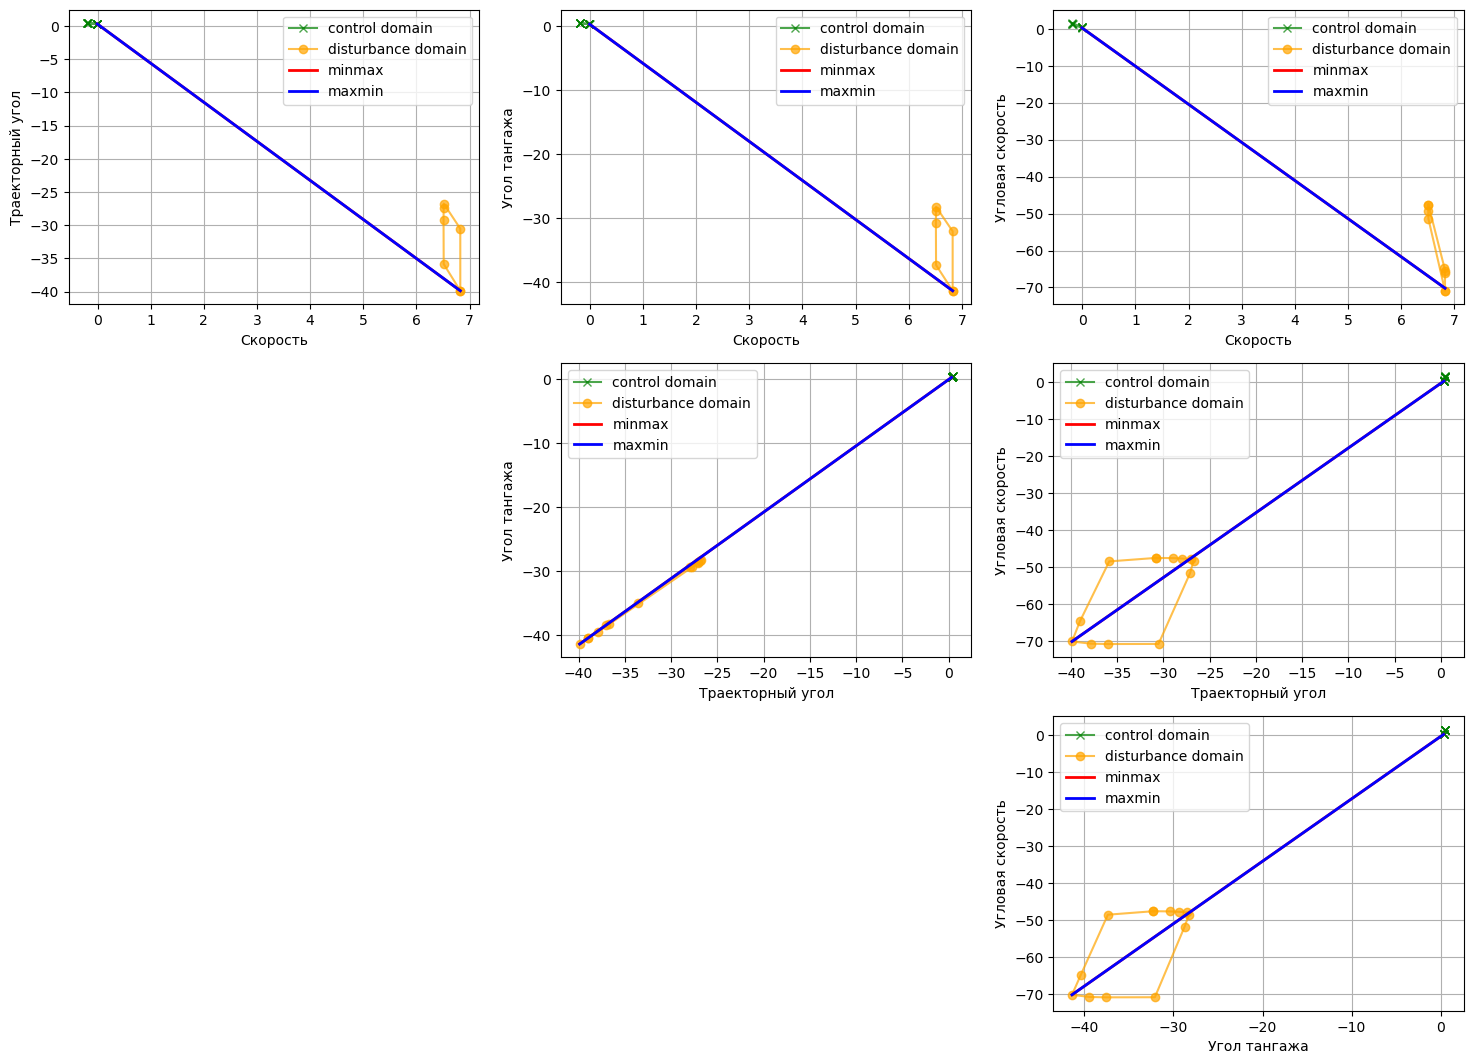

In [73]:
fig = plt.figure(figsize=(18, 13))

alpha=0.7

control_hull_01 = ConvexHull(control_domain[:, (0, 1)])
disturb_hull_01 = ConvexHull(disturbance_domain[:, (0, 1)])

control_hull_01_idx = control_hull_01.vertices.tolist() + [control_hull_01.vertices[0]]
disturb_hull_01_idx = disturb_hull_01.vertices.tolist() + [disturb_hull_01.vertices[0]]

fig.add_subplot(3, 3, 1)

plt.plot(control_domain[control_hull_01_idx, 0], control_domain[control_hull_01_idx, 1], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_01_idx, 0], disturbance_domain[disturb_hull_01_idx, 1], label="disturbance domain", color="orange", marker="o", alpha=alpha)

plt.plot(saddle_point_minmax[0][0], saddle_point_minmax[0][1], color="red")
plt.plot(saddle_point_minmax[1][0], saddle_point_minmax[1][1], color="red")
plt.plot([saddle_point_minmax[0][0], saddle_point_minmax[1][0]],
         [saddle_point_minmax[0][1], saddle_point_minmax[1][1]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][0], saddle_point_maxmin[0][1], color="blue")
plt.plot(saddle_point_maxmin[1][0], saddle_point_maxmin[1][1], color="blue")
plt.plot([saddle_point_maxmin[0][0], saddle_point_maxmin[1][0]],
         [saddle_point_maxmin[0][1], saddle_point_maxmin[1][1]],
         color="blue", label="maxmin", linewidth=2)

plt.grid()
plt.xlabel('Скорость')
plt.ylabel('Траекторный угол')
plt.legend()


control_hull_02 = ConvexHull(control_domain[:, (0, 2)])
disturb_hull_02 = ConvexHull(disturbance_domain[:, (0, 2)])

control_hull_02_idx = control_hull_02.vertices.tolist() + [control_hull_02.vertices[0]]
disturb_hull_02_idx = disturb_hull_02.vertices.tolist() + [disturb_hull_02.vertices[0]]

fig.add_subplot(3, 3, 2)

plt.plot(control_domain[control_hull_02_idx, 0], control_domain[control_hull_02_idx, 2], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_02_idx, 0], disturbance_domain[disturb_hull_02_idx, 2], label="disturbance domain", color="orange", marker="o", alpha=alpha)

plt.plot(saddle_point_minmax[0][0], saddle_point_minmax[0][2], color="red")
plt.plot(saddle_point_minmax[1][0], saddle_point_minmax[1][2], color="red")
plt.plot([saddle_point_minmax[0][0], saddle_point_minmax[1][0]],
         [saddle_point_minmax[0][2], saddle_point_minmax[1][2]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][0], saddle_point_maxmin[0][2], color="blue")
plt.plot(saddle_point_maxmin[1][0], saddle_point_maxmin[1][2], color="blue")
plt.plot([saddle_point_maxmin[0][0], saddle_point_maxmin[1][0]],
         [saddle_point_maxmin[0][2], saddle_point_maxmin[1][2]],
         color="blue", label="maxmin", linewidth=2)

plt.grid()
plt.xlabel('Скорость')
plt.ylabel('Угол тангажа')
plt.legend()



control_hull_03 = ConvexHull(control_domain[:, (0, 3)])
disturb_hull_03 = ConvexHull(disturbance_domain[:, (0, 3)])

control_hull_03_idx = control_hull_03.vertices.tolist() + [control_hull_03.vertices[0]]
disturb_hull_03_idx = disturb_hull_03.vertices.tolist() + [disturb_hull_03.vertices[0]]

fig.add_subplot(3, 3, 3)

plt.plot(control_domain[control_hull_03_idx, 0], control_domain[control_hull_03_idx, 3], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_03_idx, 0], disturbance_domain[disturb_hull_03_idx, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)

plt.plot(saddle_point_minmax[0][0], saddle_point_minmax[0][3], color="red")
plt.plot(saddle_point_minmax[1][0], saddle_point_minmax[1][3], color="red")
plt.plot([saddle_point_minmax[0][0], saddle_point_minmax[1][0]],
         [saddle_point_minmax[0][3], saddle_point_minmax[1][3]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][0], saddle_point_maxmin[0][3], color="blue")
plt.plot(saddle_point_maxmin[1][0], saddle_point_maxmin[1][3], color="blue")
plt.plot([saddle_point_maxmin[0][0], saddle_point_maxmin[1][0]],
         [saddle_point_maxmin[0][3], saddle_point_maxmin[1][3]],
         color="blue", label="maxmin", linewidth=2)

plt.grid()
plt.xlabel('Скорость')
plt.ylabel('Угловая скорость')
plt.legend()



control_hull_12 = ConvexHull(control_domain[:, (1, 2)])
disturb_hull_12 = ConvexHull(disturbance_domain[:, (1, 2)])

control_hull_12_idx = control_hull_12.vertices.tolist() + [control_hull_12.vertices[0]]
disturb_hull_12_idx = disturb_hull_12.vertices.tolist() + [disturb_hull_12.vertices[0]]

fig.add_subplot(3, 3, 5)

plt.plot(control_domain[control_hull_12_idx, 1], control_domain[control_hull_12_idx, 2], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_12_idx, 1], disturbance_domain[disturb_hull_12_idx, 2], label="disturbance domain", color="orange", marker="o", alpha=alpha)

plt.plot(saddle_point_minmax[0][1], saddle_point_minmax[0][2], color="red")
plt.plot(saddle_point_minmax[1][1], saddle_point_minmax[1][2], color="red")
plt.plot([saddle_point_minmax[0][1], saddle_point_minmax[1][1]],
         [saddle_point_minmax[0][2], saddle_point_minmax[1][2]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][1], saddle_point_maxmin[0][2], color="blue")
plt.plot(saddle_point_maxmin[1][1], saddle_point_maxmin[1][2], color="blue")
plt.plot([saddle_point_maxmin[0][1], saddle_point_maxmin[1][1]],
         [saddle_point_maxmin[0][2], saddle_point_maxmin[1][2]],
         color="blue", label="maxmin", linewidth=2)

plt.grid()
plt.xlabel('Траекторный угол')
plt.ylabel('Угол тангажа')
plt.legend()


control_hull_13 = ConvexHull(control_domain[:, (1, 3)])
disturb_hull_13 = ConvexHull(disturbance_domain[:, (1, 3)])

control_hull_13_idx = control_hull_13.vertices.tolist() + [control_hull_13.vertices[0]]
disturb_hull_13_idx = disturb_hull_13.vertices.tolist() + [disturb_hull_13.vertices[0]]

fig.add_subplot(3, 3, 6)

plt.plot(control_domain[control_hull_13_idx, 1], control_domain[control_hull_13_idx, 3], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_13_idx, 1], disturbance_domain[disturb_hull_13_idx, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)

plt.plot(saddle_point_minmax[0][1], saddle_point_minmax[0][3], color="red")
plt.plot(saddle_point_minmax[1][1], saddle_point_minmax[1][3], color="red")
plt.plot([saddle_point_minmax[0][1], saddle_point_minmax[1][1]],
         [saddle_point_minmax[0][3], saddle_point_minmax[1][3]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][1], saddle_point_maxmin[0][3], color="blue")
plt.plot(saddle_point_maxmin[1][1], saddle_point_maxmin[1][3], color="blue")
plt.plot([saddle_point_maxmin[0][1], saddle_point_maxmin[1][1]],
         [saddle_point_maxmin[0][3], saddle_point_maxmin[1][3]],
         color="blue", label="maxmin", linewidth=2)

plt.grid()
plt.xlabel('Траекторный угол')
plt.ylabel('Угловая скорость')
plt.legend()



control_hull_23 = ConvexHull(control_domain[:, (2, 3)])
disturb_hull_23 = ConvexHull(disturbance_domain[:, (2, 3)])

control_hull_23_idx = control_hull_23.vertices.tolist() + [control_hull_23.vertices[0]]
disturb_hull_23_idx = disturb_hull_23.vertices.tolist() + [disturb_hull_23.vertices[0]]

fig.add_subplot(3, 3, 9)

plt.plot(control_domain[control_hull_23_idx, 2], control_domain[control_hull_23_idx, 3], label="control domain", color="green", marker="x", alpha=alpha)
plt.plot(disturbance_domain[disturb_hull_23_idx, 2], disturbance_domain[disturb_hull_23_idx, 3], label="disturbance domain", color="orange", marker="o", alpha=alpha)

plt.plot(saddle_point_minmax[0][2], saddle_point_minmax[0][3], color="red")
plt.plot(saddle_point_minmax[1][2], saddle_point_minmax[1][3], color="red")
plt.plot([saddle_point_minmax[0][2], saddle_point_minmax[1][2]],
         [saddle_point_minmax[0][3], saddle_point_minmax[1][3]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][2], saddle_point_maxmin[0][3], color="blue")
plt.plot(saddle_point_maxmin[1][2], saddle_point_maxmin[1][3], color="blue")
plt.plot([saddle_point_maxmin[0][2], saddle_point_maxmin[1][2]],
         [saddle_point_maxmin[0][3], saddle_point_maxmin[1][3]],
         color="blue", label="maxmin", linewidth=2)

plt.grid()
plt.xlabel('Угол тангажа')
plt.ylabel('Угловая скорость')
plt.legend()

plt.show()

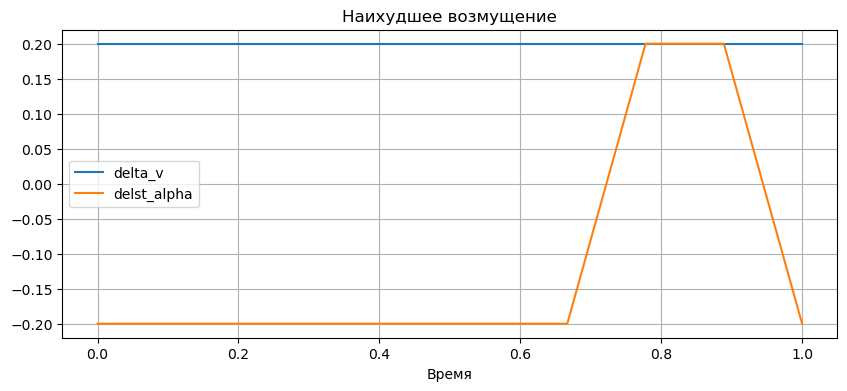

In [74]:
plt.figure(figsize=(10,4))
plt.plot(np.linspace(0, tk, int(tk*10)), list_all_disturbance[idx_maxmin][:, 0], label="delta_v")
plt.plot(np.linspace(0, tk, int(tk*10)), list_all_disturbance[idx_maxmin][:, 1], label="delst_alpha")
plt.grid()
plt.legend()
plt.title('Наихудшее возмущение')
plt.xlabel('Время')
plt.show()

In [53]:
tk = 1
z0 = np.array([0, 0, 0, 0])

np.random.seed(42)
init_ratio = 2
y0 = init_ratio * np.random.random(4)

grid_c = np.array([x / np.linalg.norm(x) for x in itertools.product(np.linspace(-1, 1, 4),
                                                                    np.linspace(-1, 1, 4),
                                                                    np.linspace(-1, 1, 4),
                                                                    np.linspace(-1, 1, 4))])    


control_domain, disturbance_domain = get_attainability_domains(tk, z0, y0, grid_c, matrix_A, matrix_B, matrix_C,
                                                              u1_min=0, u1_max=2, u2_min= -3, u2_max=3,
                                                              v1_min= -1.5, v1_max=1.5, v2_min= -2, v2_max=2)

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:10<00:00, 24.14it/s]


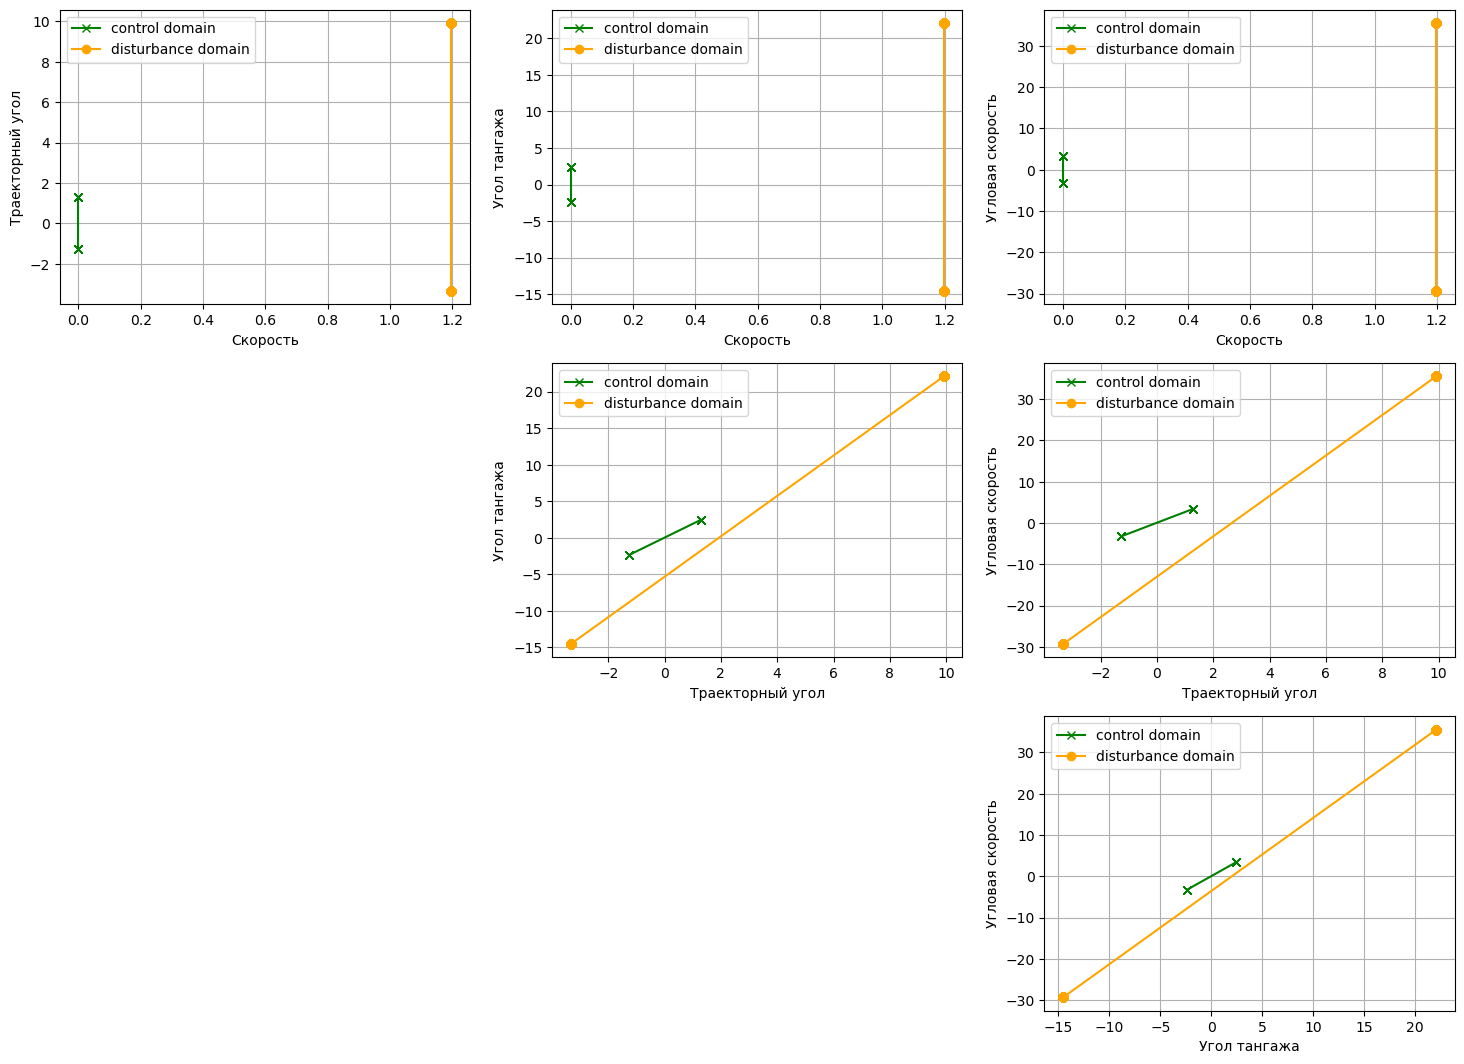

In [35]:
fig = plt.figure(figsize=(18, 13))

fig.add_subplot(3, 3, 1)
plt.plot(control_domain[:, 0], control_domain[:, 1], label="control domain", color="green", marker="x")
plt.plot(disturbance_domain[:, 0], disturbance_domain[:, 1], label="disturbance domain", color="orange", marker="o")
plt.grid()
plt.xlabel('Скорость')
plt.ylabel('Траекторный угол')
plt.legend()

fig.add_subplot(3, 3, 2)
plt.plot(control_domain[:, 0], control_domain[:, 2], label="control domain", color="green", marker="x")
plt.plot(disturbance_domain[:, 0], disturbance_domain[:, 2], label="disturbance domain", color="orange", marker="o")
plt.grid()
plt.xlabel('Скорость')
plt.ylabel('Угол тангажа')
plt.legend()

fig.add_subplot(3, 3, 3)
plt.plot(control_domain[:, 0], control_domain[:, 3], label="control domain", color="green", marker="x")
plt.plot(disturbance_domain[:, 0], disturbance_domain[:, 3], label="disturbance domain", color="orange", marker="o")
plt.grid()
plt.xlabel('Скорость')
plt.ylabel('Угловая скорость')
plt.legend()

fig.add_subplot(3, 3, 5)
plt.plot(control_domain[:, 1], control_domain[:, 2], label="control domain", color="green", marker="x")
plt.plot(disturbance_domain[:, 1], disturbance_domain[:, 2], label="disturbance domain", color="orange", marker="o")
plt.grid()
plt.xlabel('Траекторный угол')
plt.ylabel('Угол тангажа')
plt.legend()

fig.add_subplot(3, 3, 6)
plt.plot(control_domain[:, 1], control_domain[:, 3], label="control domain", color="green", marker="x")
plt.plot(disturbance_domain[:, 1], disturbance_domain[:, 3], label="disturbance domain", color="orange", marker="o")
plt.grid()
plt.xlabel('Траекторный угол')
plt.ylabel('Угловая скорость')
plt.legend()

fig.add_subplot(3, 3, 9)
plt.plot(control_domain[:, 2], control_domain[:, 3], label="control domain", color="green", marker="x")
plt.plot(disturbance_domain[:, 2], disturbance_domain[:, 3], label="disturbance domain", color="orange", marker="o")
plt.grid()
plt.xlabel('Угол тангажа')
plt.ylabel('Угловая скорость')
plt.legend()

plt.show()

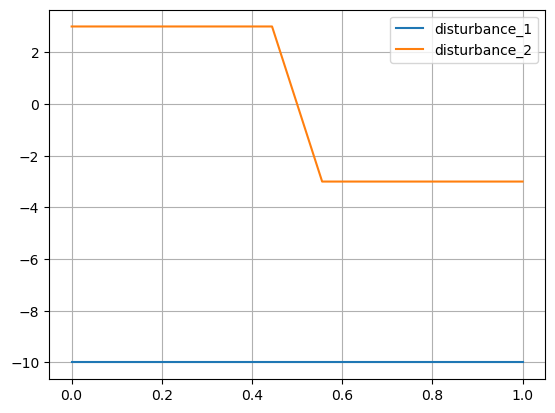

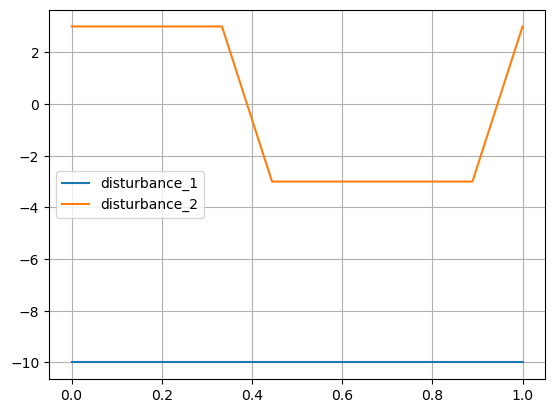

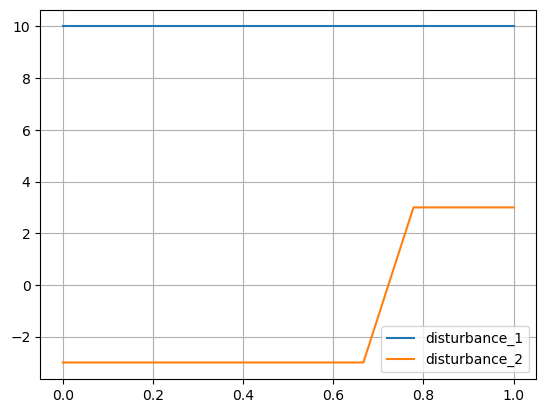

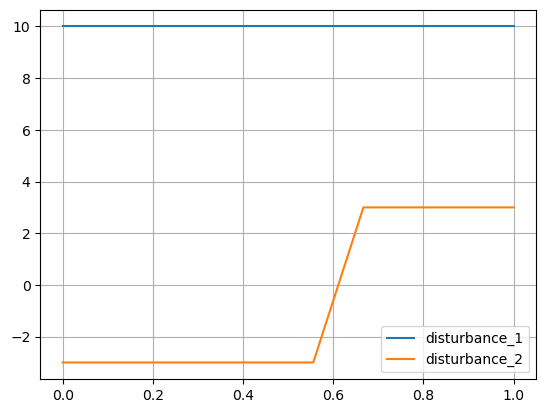

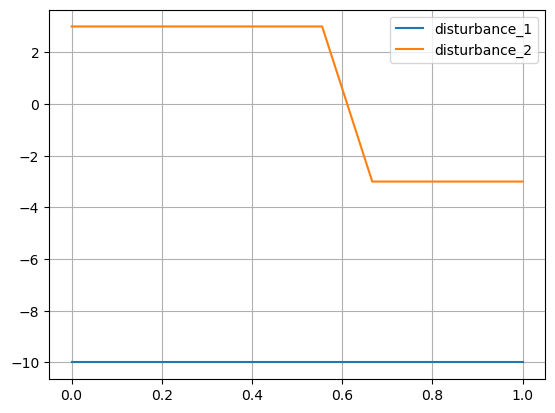

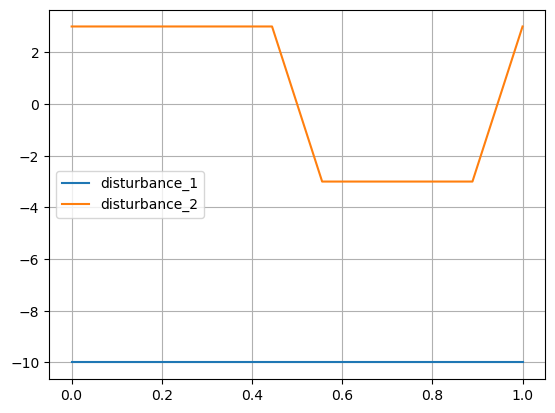

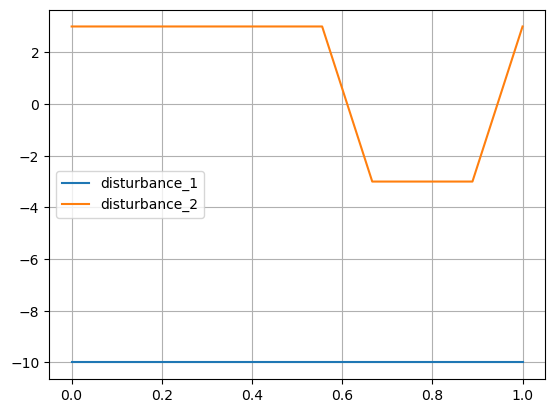

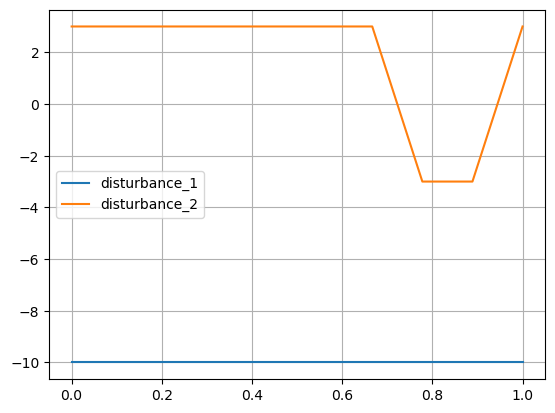

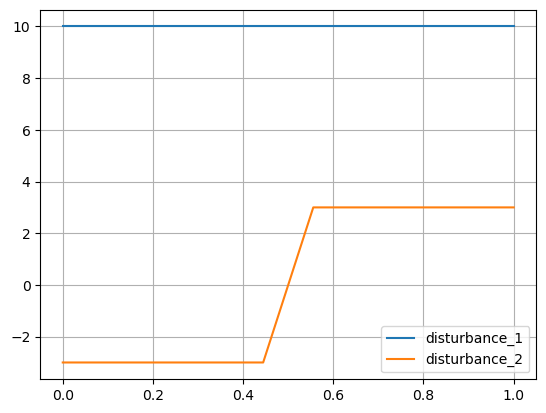

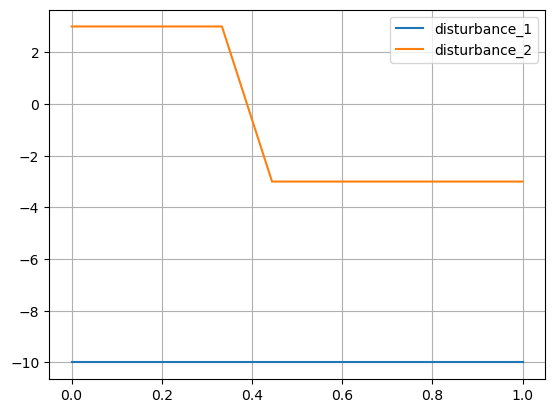

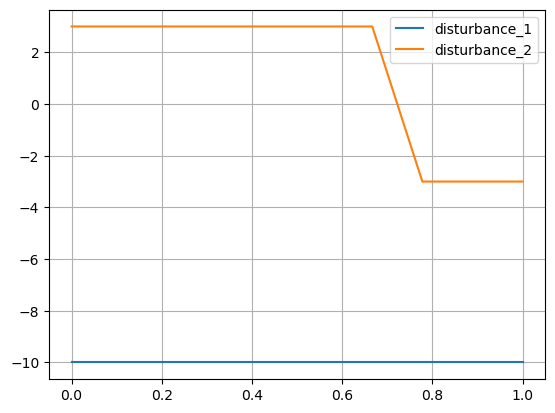

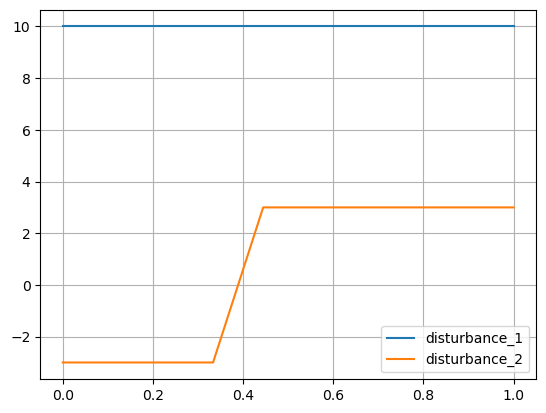

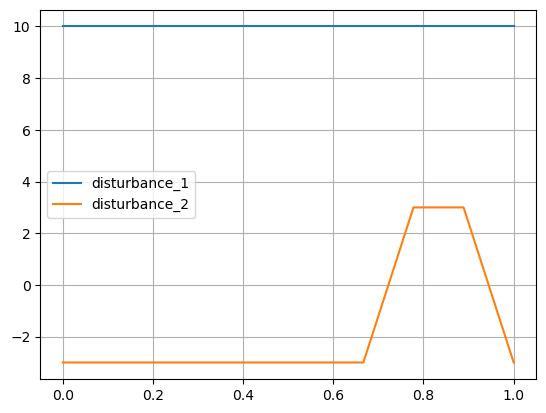

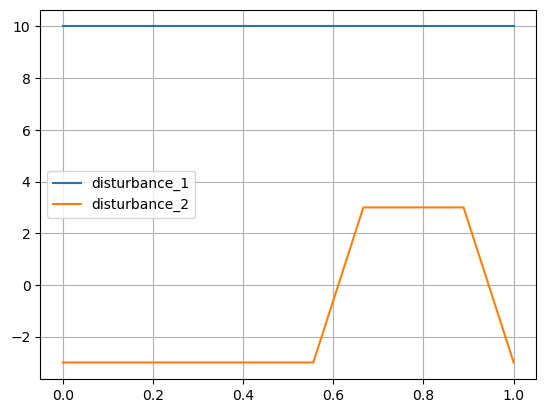

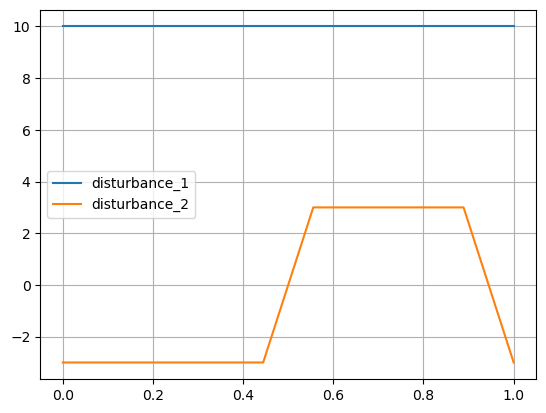

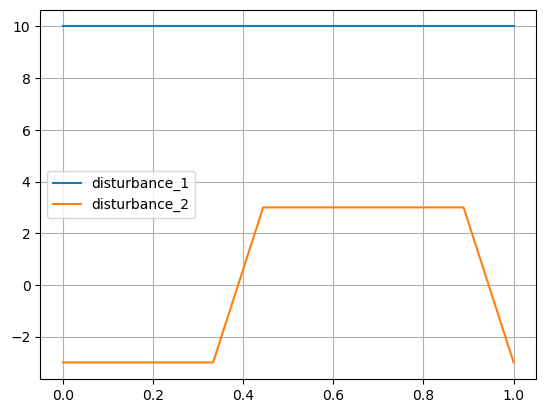

In [44]:
# fig = plt.figure(figsize=(12, 8))
n_disturbances = len(list_diff_disturbance)

for i in range(n_disturbances):
    # fig.add_subplot(n_disturbances, 2, i+1)
    plt.plot(np.linspace(0, tk, int(tk*10)), list_diff_disturbance[i][:, 0], label="disturbance_1")
    plt.plot(np.linspace(0, tk, int(tk*10)), list_diff_disturbance[i][:, 1], label="disturbance_2")
    plt.grid()
    plt.legend()
    plt.show()

In [37]:
minmax, saddle_point_minmax = find_minmax(control_domain, disturbance_domain)
maxmin, saddle_point_maxmin = find_maxmin(control_domain, disturbance_domain)

In [38]:
print(minmax, maxmin)

840.4014794592698 840.4014794592698


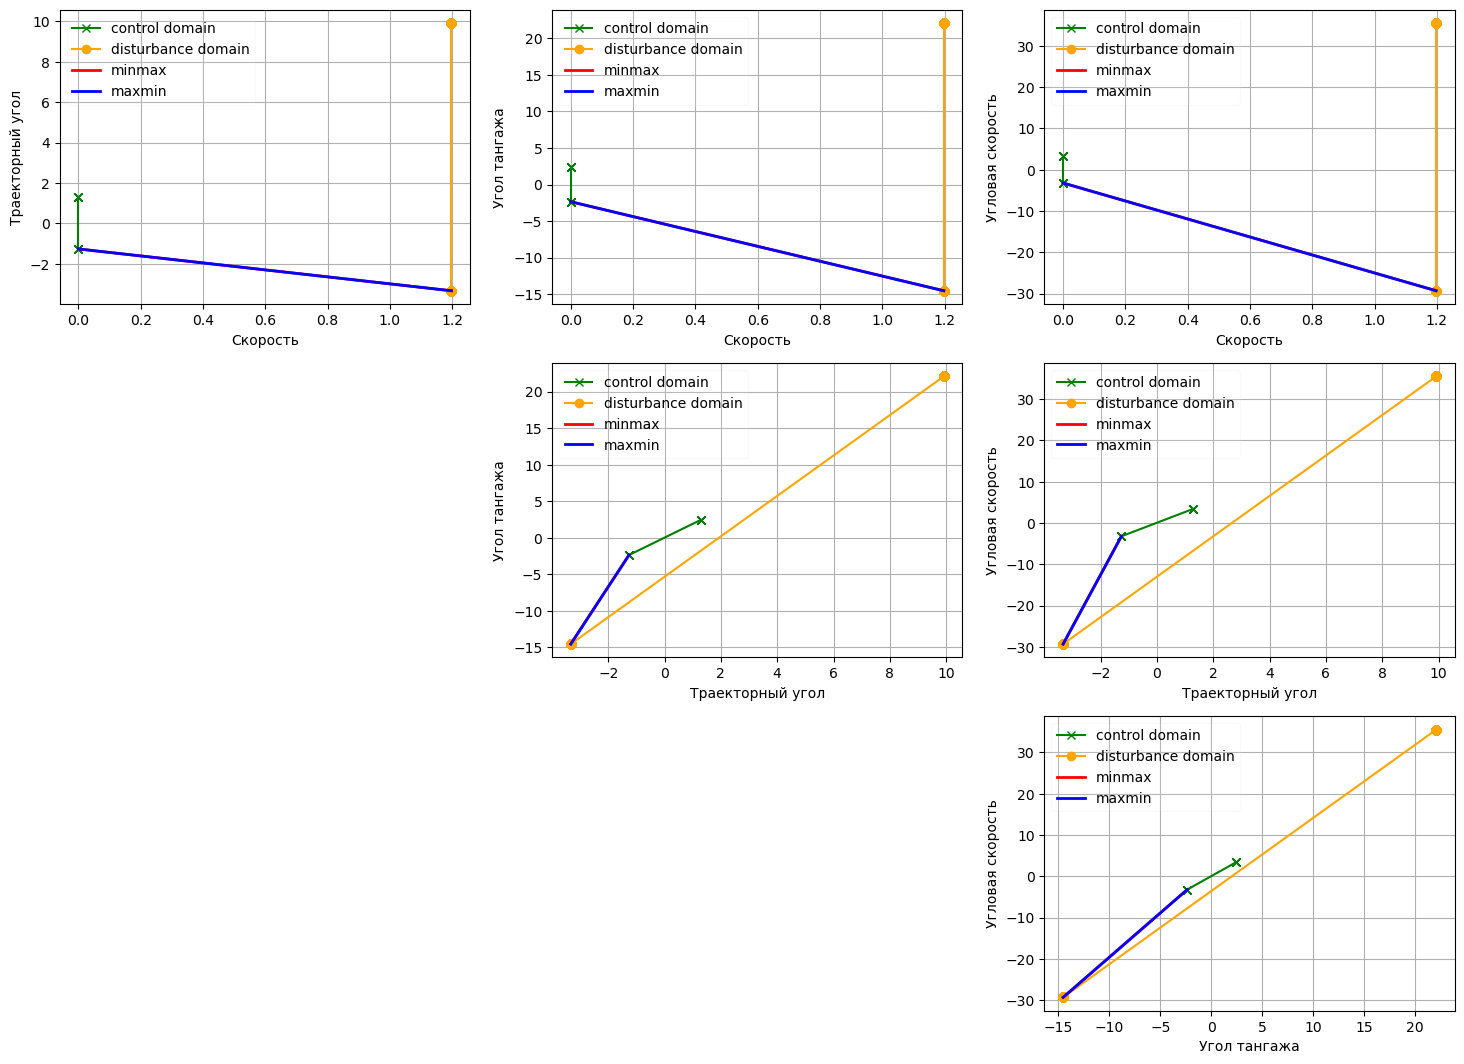

In [40]:
fig = plt.figure(figsize=(18, 13))

fig.add_subplot(3, 3, 1)
plt.plot(control_domain[:, 0], control_domain[:, 1], label="control domain", color="green", marker="x")
plt.plot(disturbance_domain[:, 0], disturbance_domain[:, 1], label="disturbance domain", color="orange", marker="o")

plt.plot(saddle_point_minmax[0][0], saddle_point_minmax[0][1], color="red")
plt.plot(saddle_point_minmax[1][0], saddle_point_minmax[1][1], color="red")
plt.plot([saddle_point_minmax[0][0], saddle_point_minmax[1][0]],
         [saddle_point_minmax[0][1], saddle_point_minmax[1][1]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][0], saddle_point_maxmin[0][1], color="blue")
plt.plot(saddle_point_maxmin[1][0], saddle_point_maxmin[1][1], color="blue")
plt.plot([saddle_point_maxmin[0][0], saddle_point_maxmin[1][0]],
         [saddle_point_maxmin[0][1], saddle_point_maxmin[1][1]],
         color="blue", label="maxmin", linewidth=2)

plt.xlabel('Скорость')
plt.ylabel('Траекторный угол')
plt.grid()
plt.legend(framealpha=0.1)



fig.add_subplot(3, 3, 2)
plt.plot(control_domain[:, 0], control_domain[:, 2], label="control domain", color="green", marker="x")
plt.plot(disturbance_domain[:, 0], disturbance_domain[:, 2], label="disturbance domain", color="orange", marker="o")

plt.plot(saddle_point_minmax[0][0], saddle_point_minmax[0][2], color="red")
plt.plot(saddle_point_minmax[1][0], saddle_point_minmax[1][2], color="red")
plt.plot([saddle_point_minmax[0][0], saddle_point_minmax[1][0]],
         [saddle_point_minmax[0][2], saddle_point_minmax[1][2]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][0], saddle_point_maxmin[0][2], color="blue")
plt.plot(saddle_point_maxmin[1][0], saddle_point_maxmin[1][2], color="blue")
plt.plot([saddle_point_maxmin[0][0], saddle_point_maxmin[1][0]],
         [saddle_point_maxmin[0][2], saddle_point_maxmin[1][2]],
         color="blue", label="maxmin", linewidth=2)

plt.xlabel('Скорость')
plt.ylabel('Угол тангажа')
plt.grid()
plt.legend(framealpha=0.1)




fig.add_subplot(3, 3, 3)
plt.plot(control_domain[:, 0], control_domain[:, 3], label="control domain", color="green", marker="x")
plt.plot(disturbance_domain[:, 0], disturbance_domain[:, 3], label="disturbance domain", color="orange", marker="o")

plt.plot(saddle_point_minmax[0][0], saddle_point_minmax[0][3], color="red")
plt.plot(saddle_point_minmax[1][0], saddle_point_minmax[1][3], color="red")
plt.plot([saddle_point_minmax[0][0], saddle_point_minmax[1][0]],
         [saddle_point_minmax[0][3], saddle_point_minmax[1][3]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][0], saddle_point_maxmin[0][3], color="blue")
plt.plot(saddle_point_maxmin[1][0], saddle_point_maxmin[1][3], color="blue")
plt.plot([saddle_point_maxmin[0][0], saddle_point_maxmin[1][0]],
         [saddle_point_maxmin[0][3], saddle_point_maxmin[1][3]],
         color="blue", label="maxmin", linewidth=2)

plt.xlabel('Скорость')
plt.ylabel('Угловая скорость')
plt.grid()
plt.legend(framealpha=0.1)



fig.add_subplot(3, 3, 5)
plt.plot(control_domain[:, 1], control_domain[:, 2], label="control domain", color="green", marker="x")
plt.plot(disturbance_domain[:, 1], disturbance_domain[:, 2], label="disturbance domain", color="orange", marker="o")

plt.plot(saddle_point_minmax[0][1], saddle_point_minmax[0][2], color="red")
plt.plot(saddle_point_minmax[1][1], saddle_point_minmax[1][2], color="red")
plt.plot([saddle_point_minmax[0][1], saddle_point_minmax[1][1]],
         [saddle_point_minmax[0][2], saddle_point_minmax[1][2]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][1], saddle_point_maxmin[0][2], color="blue")
plt.plot(saddle_point_maxmin[1][1], saddle_point_maxmin[1][2], color="blue")
plt.plot([saddle_point_maxmin[0][1], saddle_point_maxmin[1][1]],
         [saddle_point_maxmin[0][2], saddle_point_maxmin[1][2]],
         color="blue", label="maxmin", linewidth=2)

plt.xlabel('Траекторный угол')
plt.ylabel('Угол тангажа')
plt.grid()
plt.legend(framealpha=0.1)



fig.add_subplot(3, 3, 6)
plt.plot(control_domain[:, 1], control_domain[:, 3], label="control domain", color="green", marker="x")
plt.plot(disturbance_domain[:, 1], disturbance_domain[:, 3], label="disturbance domain", color="orange", marker="o")

plt.plot(saddle_point_minmax[0][1], saddle_point_minmax[0][3], color="red")
plt.plot(saddle_point_minmax[1][1], saddle_point_minmax[1][3], color="red")
plt.plot([saddle_point_minmax[0][1], saddle_point_minmax[1][1]],
         [saddle_point_minmax[0][3], saddle_point_minmax[1][3]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][1], saddle_point_maxmin[0][3], color="blue")
plt.plot(saddle_point_maxmin[1][1], saddle_point_maxmin[1][3], color="blue")
plt.plot([saddle_point_maxmin[0][1], saddle_point_maxmin[1][1]],
         [saddle_point_maxmin[0][3], saddle_point_maxmin[1][3]],
         color="blue", label="maxmin", linewidth=2)

plt.xlabel('Траекторный угол')
plt.ylabel('Угловая скорость')
plt.grid()
plt.legend(framealpha=0.1)



fig.add_subplot(3, 3, 9)
plt.plot(control_domain[:, 2], control_domain[:, 3], label="control domain", color="green", marker="x")
plt.plot(disturbance_domain[:, 2], disturbance_domain[:, 3], label="disturbance domain", color="orange", marker="o")

plt.plot(saddle_point_minmax[0][2], saddle_point_minmax[0][3], color="red")
plt.plot(saddle_point_minmax[1][2], saddle_point_minmax[1][3], color="red")
plt.plot([saddle_point_minmax[0][2], saddle_point_minmax[1][2]],
         [saddle_point_minmax[0][3], saddle_point_minmax[1][3]],
         color="red", label="minmax", linewidth=2)

plt.plot(saddle_point_maxmin[0][2], saddle_point_maxmin[0][3], color="blue")
plt.plot(saddle_point_maxmin[1][2], saddle_point_maxmin[1][3], color="blue")
plt.plot([saddle_point_maxmin[0][2], saddle_point_maxmin[1][2]],
         [saddle_point_maxmin[0][3], saddle_point_maxmin[1][3]],
         color="blue", label="maxmin", linewidth=2)

plt.xlabel('Угол тангажа')
plt.ylabel('Угловая скорость')
plt.grid()
plt.legend(framealpha=0.1)


plt.show()